<a href="https://colab.research.google.com/github/achelousace/Chicago-Crimes-Timeseries-Analysis/blob/main/Chicago_Crimes_Timeseries_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chicago Crimes Timeseries Analysis/Modeling
## by: Mohammad Abu Ayyash

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
folder ="/content/drive/MyDrive/Chicago_Crime.csv"
df = pd.read_csv(folder)

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
SEED = 42
np.random.seed(SEED)
pd.set_option('display.max_columns',50)
import statsmodels.tsa.api as tsa
from scipy.signal import find_peaks

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

# Data Inspecting

In [5]:
df.head()

ID                    Date     Primary Type          Description     Location Description  Arrest  Domestic  Beat  District  Ward   Latitude  Longitude
0  1326041  01/01/2001 01:00:00 AM          BATTERY               SIMPLE                RESIDENCE   False     False  1624      16.0   NaN  41.957850 -87.749185
1  1319931  01/01/2001 01:00:00 PM          BATTERY               SIMPLE                RESIDENCE   False      True   825       8.0   NaN  41.783892 -87.684841
2  1324743  01/01/2001 01:00:00 PM         GAMBLING  ILLEGAL ILL LOTTERY                   STREET    True     False   313       3.0   NaN  41.780412 -87.611970
3  1310717  01/01/2001 01:00:00 AM  CRIMINAL DAMAGE           TO VEHICLE                   STREET   False     False  2424      24.0   NaN  42.012391 -87.678032
4  1318099  01/01/2001 01:00:00 AM          BATTERY               SIMPLE  RESIDENCE PORCH/HALLWAY   False      True   214       2.0   NaN  41.819538 -87.620020

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 603.2+ MB


In [7]:
df.isna().sum()/len(df)

ID                      0.000000
Date                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.001417
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.000006
Ward                    0.079714
Latitude                0.011498
Longitude               0.011498
dtype: float64

In [8]:
df=df.drop(columns=['ID','Latitude','Longitude','Ward'])

# Data Preprocessing

## Timeseries Preprocessing

In [9]:
df.head()

Date     Primary Type          Description     Location Description  Arrest  Domestic  Beat  District
0  01/01/2001 01:00:00 AM          BATTERY               SIMPLE                RESIDENCE   False     False  1624      16.0
1  01/01/2001 01:00:00 PM          BATTERY               SIMPLE                RESIDENCE   False      True   825       8.0
2  01/01/2001 01:00:00 PM         GAMBLING  ILLEGAL ILL LOTTERY                   STREET    True     False   313       3.0
3  01/01/2001 01:00:00 AM  CRIMINAL DAMAGE           TO VEHICLE                   STREET   False     False  2424      24.0
4  01/01/2001 01:00:00 AM          BATTERY               SIMPLE  RESIDENCE PORCH/HALLWAY   False      True   214       2.0

In [10]:
df['AM/PM'] = df['Date'].apply(lambda x: 'AM' if 'AM' in x else 'PM')

In [11]:
df['datetime'] = pd.to_datetime(df['Date'],errors='coerce')

In [12]:
df.head()

Date     Primary Type          Description     Location Description  Arrest  Domestic  Beat  District AM/PM            datetime
0  01/01/2001 01:00:00 AM          BATTERY               SIMPLE                RESIDENCE   False     False  1624      16.0    AM 2001-01-01 01:00:00
1  01/01/2001 01:00:00 PM          BATTERY               SIMPLE                RESIDENCE   False      True   825       8.0    PM 2001-01-01 13:00:00
2  01/01/2001 01:00:00 PM         GAMBLING  ILLEGAL ILL LOTTERY                   STREET    True     False   313       3.0    PM 2001-01-01 13:00:00
3  01/01/2001 01:00:00 AM  CRIMINAL DAMAGE           TO VEHICLE                   STREET   False     False  2424      24.0    AM 2001-01-01 01:00:00
4  01/01/2001 01:00:00 AM          BATTERY               SIMPLE  RESIDENCE PORCH/HALLWAY   False      True   214       2.0    AM 2001-01-01 01:00:00

In [13]:
df = df.drop(columns=['Date'])

In [14]:
df.head()

Primary Type          Description     Location Description  Arrest  Domestic  Beat  District AM/PM            datetime
0          BATTERY               SIMPLE                RESIDENCE   False     False  1624      16.0    AM 2001-01-01 01:00:00
1          BATTERY               SIMPLE                RESIDENCE   False      True   825       8.0    PM 2001-01-01 13:00:00
2         GAMBLING  ILLEGAL ILL LOTTERY                   STREET    True     False   313       3.0    PM 2001-01-01 13:00:00
3  CRIMINAL DAMAGE           TO VEHICLE                   STREET   False     False  2424      24.0    AM 2001-01-01 01:00:00
4          BATTERY               SIMPLE  RESIDENCE PORCH/HALLWAY   False      True   214       2.0    AM 2001-01-01 01:00:00

In [15]:
df = df.set_index('datetime')

In [16]:
df.head()

Primary Type          Description     Location Description  Arrest  Domestic  Beat  District AM/PM
datetime                                                                                                                  
2001-01-01 01:00:00          BATTERY               SIMPLE                RESIDENCE   False     False  1624      16.0    AM
2001-01-01 13:00:00          BATTERY               SIMPLE                RESIDENCE   False      True   825       8.0    PM
2001-01-01 13:00:00         GAMBLING  ILLEGAL ILL LOTTERY                   STREET    True     False   313       3.0    PM
2001-01-01 01:00:00  CRIMINAL DAMAGE           TO VEHICLE                   STREET   False     False  2424      24.0    AM
2001-01-01 01:00:00          BATTERY               SIMPLE  RESIDENCE PORCH/HALLWAY   False      True   214       2.0    AM

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7713109 entries, 2001-01-01 01:00:00 to 2022-12-31 12:59:00
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Primary Type          object 
 1   Description           object 
 2   Location Description  object 
 3   Arrest                bool   
 4   Domestic              bool   
 5   Beat                  int64  
 6   District              float64
 7   AM/PM                 object 
dtypes: bool(2), float64(1), int64(1), object(4)
memory usage: 426.6+ MB


In [18]:
df.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 13:00:00', '2001-01-01 13:00:00', '2001-01-01 01:00:00', '2001-01-01 01:00:00', '2001-01-01 01:00:00', '2001-01-01 01:00:00', '2001-01-01 01:00:00', '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               ...
               '2022-12-31 12:41:00', '2022-12-31 00:42:00', '2022-12-31 00:44:00', '2022-12-31 00:45:00', '2022-12-31 12:45:00', '2022-12-31 12:50:00', '2022-12-31 12:50:00', '2022-12-31 00:52:00', '2022-12-31 12:52:00', '2022-12-31 12:59:00'],
              dtype='datetime64[ns]', name='datetime', length=7713109, freq=None)

## Handling Inconsistencies

In [19]:
df['Primary Type'] = df['Primary Type'].replace(['NON - CRIMINAL', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)'], 'NON-CRIMINAL')
df['Primary Type'] = df['Primary Type'].replace(['CRIM SEXUAL ASSAULT','SEX OFFENSE','PROSTITUTION','CRIMINAL SEXUAL ASSAULT'],'Sexual Crime')
df['Primary Type'].value_counts()

Primary Type
THEFT                                1626992
BATTERY                              1410889
CRIMINAL DAMAGE                       878914
NARCOTICS                             746155
ASSAULT                               501103
OTHER OFFENSE                         479174
BURGLARY                              422246
MOTOR VEHICLE THEFT                   366586
DECEPTIVE PRACTICE                    340958
ROBBERY                               289677
CRIMINAL TRESPASS                     212869
Sexual Crime                          134129
WEAPONS VIOLATION                     103906
OFFENSE INVOLVING CHILDREN             55280
PUBLIC PEACE VIOLATION                 52086
INTERFERENCE WITH PUBLIC OFFICER       18206
LIQUOR LAW VIOLATION                   14846
GAMBLING                               14616
ARSON                                  13121
HOMICIDE                               12394
KIDNAPPING                              7185
STALKING                                4664
INTIMIDATION                            4595
CONCEALED CARRY LICENSE VIOLATION       1019
OBSCENITY                                810
NON-CRIMINAL                             228
PUBLIC INDECENCY                         193
OTHER NARCOTIC VIOLATION                 147
HUMAN TRAFFICKING                         96
RITUALISM                                 24
DOMESTIC VIOLENCE                          1
Name: count, dtype: int64

## Handling Null Values

In [20]:
df.isna().sum()/len(df)

Primary Type            0.000000
Description             0.000000
Location Description    0.001417
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.000006
AM/PM                   0.000000
dtype: float64

In [21]:
df['Location Description'].isna().sum()

10928

In [22]:
df[df['Location Description'].isna()]

Primary Type                              Description Location Description  Arrest  Domestic  Beat  District AM/PM
datetime                                                                                                                                     
2001-03-18 21:37:10             BATTERY                                   SIMPLE                  NaN   False     False  1031      10.0    PM
2001-03-22 00:30:00  DECEPTIVE PRACTICE            STOLEN PROP: BUY/RECEIVE/POS.                  NaN    True     False  1924      19.0    AM
2001-09-12 11:10:00  DECEPTIVE PRACTICE      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False     False   111       1.0    AM
2001-10-02 16:30:00  DECEPTIVE PRACTICE      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False     False   434       4.0    PM
2001-12-05 14:45:00  DECEPTIVE PRACTICE      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False     False   412       4.0    PM
...                                 ...                                      ...                  ...     ...       ...   ...       ...   ...
2022-12-30 17:02:00  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT $300 AND UNDER                  NaN   False     False  1133      11.0    PM
2022-12-30 09:00:00  DECEPTIVE PRACTICE      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False     False  2423      24.0    AM
2022-12-30 09:20:00  DECEPTIVE PRACTICE      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False     False  1922      19.0    AM
2022-12-30 23:05:00  DECEPTIVE PRACTICE      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False     False  1932      19.0    PM
2022-12-31 15:35:00  DECEPTIVE PRACTICE      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False     False  1934      19.0    PM

[10928 rows x 8 columns]

In [23]:
df.loc[['2001-03-18 21:37:10']]

Primary Type Description Location Description  Arrest  Domestic  Beat  District AM/PM
datetime                                                                                                 
2001-03-18 21:37:10      BATTERY      SIMPLE                  NaN   False     False  1031      10.0    PM

In [24]:
# Find the most common location description for each primary type
most_common_locations = df.groupby('Primary Type')['Location Description'].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()

# Fill NaN values in 'Location Description' based on 'Primary Type'
df['Location Description'] = df.apply(lambda row: most_common_locations.get(row['Primary Type']) if pd.isna(row['Location Description']) else row['Location Description'], axis=1)


In [25]:
df[df['Primary Type']=='BATTERY'].mode()

Primary Type              Description Location Description  Arrest  Domestic  Beat  District AM/PM
0      BATTERY  DOMESTIC BATTERY SIMPLE            APARTMENT   False      True   421       7.0    PM

In [26]:
df['Location Description'].isna().sum()

0

In [27]:
df['District'].describe()

count    7.713062e+06
mean     1.129533e+01
std      6.951157e+00
min      1.000000e+00
25%      6.000000e+00
50%      1.000000e+01
75%      1.700000e+01
max      3.100000e+01
Name: District, dtype: float64

In [28]:
df['District'].isna().sum()

47

In [29]:
district_median = df['District'].median()
df['District'] = df['District'].fillna(district_median)

In [30]:
df['District'].isna().sum()

0

## Dataframe Duplicates

In [31]:
df[df.duplicated()]

Primary Type                              Description          Location Description  Arrest  Domestic  Beat  District AM/PM
datetime                                                                                                                                              
2001-01-01 01:00:00     CRIMINAL DAMAGE                               TO VEHICLE                        STREET   False     False  1913      19.0    AM
2001-01-01 01:23:32             BATTERY                                   SIMPLE                    RESTAURANT    True     False  1834      18.0    AM
2001-01-01 01:25:22               THEFT                           $500 AND UNDER                 BAR OR TAVERN   False     False   921       9.0    AM
2001-01-01 01:40:44   WEAPONS VIOLATION                 UNLAWFUL POSS OF HANDGUN                      SIDEWALK   False     False   434       4.0    AM
2001-01-01 02:00:00     CRIMINAL DAMAGE                               TO VEHICLE                        STREET   False     False  1223      12.0    AM
...                                 ...                                      ...                           ...     ...       ...   ...       ...   ...
2022-12-31 12:45:00     CRIMINAL DAMAGE                              TO PROPERTY            SMALL RETAIL STORE   False     False  1131      11.0    PM
2022-12-31 12:50:00             ASSAULT                                   SIMPLE                     APARTMENT   False     False  1014      10.0    PM
2022-12-31 12:50:00             ASSAULT                     AGGRAVATED - HANDGUN                     APARTMENT   False      True   733       7.0    PM
2022-12-31 12:52:00             ASSAULT                                   SIMPLE  COMMERCIAL / BUSINESS OFFICE   False     False  1432      14.0    PM
2022-12-31 12:59:00  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT $300 AND UNDER                     RESIDENCE   False     False  1511      15.0    PM

[6590193 rows x 8 columns]

# Time Series Analysis

## Comparing Police Districts

In [32]:
df['year'] = df.index.year

In [33]:
df.head()

Primary Type          Description     Location Description  Arrest  Domestic  Beat  District AM/PM  year
datetime                                                                                                                        
2001-01-01 01:00:00          BATTERY               SIMPLE                RESIDENCE   False     False  1624      16.0    AM  2001
2001-01-01 13:00:00          BATTERY               SIMPLE                RESIDENCE   False      True   825       8.0    PM  2001
2001-01-01 13:00:00         GAMBLING  ILLEGAL ILL LOTTERY                   STREET    True     False   313       3.0    PM  2001
2001-01-01 01:00:00  CRIMINAL DAMAGE           TO VEHICLE                   STREET   False     False  2424      24.0    AM  2001
2001-01-01 01:00:00          BATTERY               SIMPLE  RESIDENCE PORCH/HALLWAY   False      True   214       2.0    AM  2001

In [34]:
crime2022 = df[df['year'] == 2022]

In [35]:
crime2022.head()

Primary Type                              Description                    Location Description  Arrest  Domestic  Beat  District AM/PM  year
datetime                                                                                                                                                              
2022-01-01 13:00:00               THEFT                           $500 AND UNDER                              RESTAURANT   False     False   121       1.0    PM  2022
2022-01-01 13:00:00  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT $300 AND UNDER                                    BANK   False     False   811       8.0    PM  2022
2022-01-01 01:00:00     CRIMINAL DAMAGE                               TO VEHICLE  PARKING LOT / GARAGE (NON RESIDENTIAL)   False     False   531       5.0    AM  2022
2022-01-01 01:00:00       OTHER OFFENSE                  HARASSMENT BY TELEPHONE                               APARTMENT   False     False   412       4.0    AM  2022
2022-01-01 01:00:00               THEFT                           $500 AND UNDER                         OTHER (SPECIFY)   False     False  1811      18.0    AM  2022

In [36]:
max_date = crime2022['District'].value_counts().idxmax()
max_value = crime2022['District'].value_counts().max()

print(f"Most crimes in 2022 for district {max_date} with {max_value} crimes")

min_date = crime2022['District'].value_counts().idxmin()
min_value = crime2022['District'].value_counts().min()

print(f"Least crimes in 2022 for district {min_date} with {min_value} crimes")

Most crimes in 2022 for district 8.0 with 14805 crimes
Least crimes in 2022 for district 31.0 with 15 crimes


## Crimes Across the Years

In [37]:
year_counts = df['year'].value_counts()

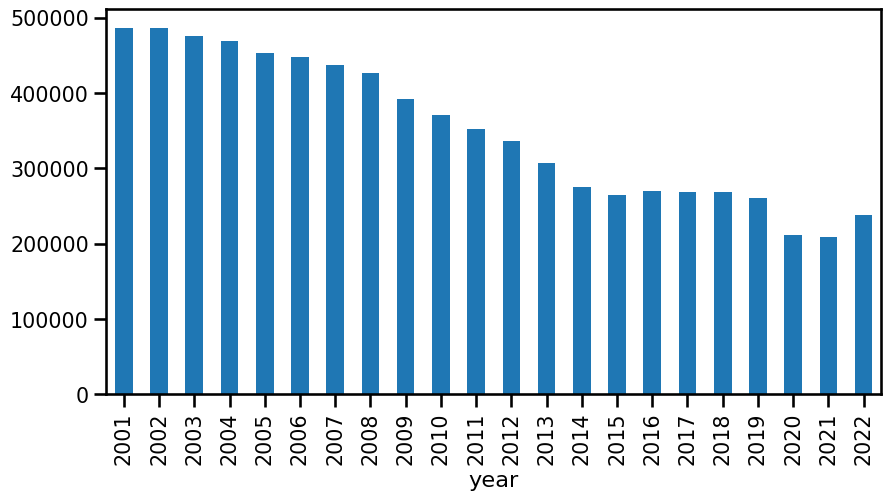

In [38]:
year_counts.sort_index().plot(kind='bar',figsize=(10,5));

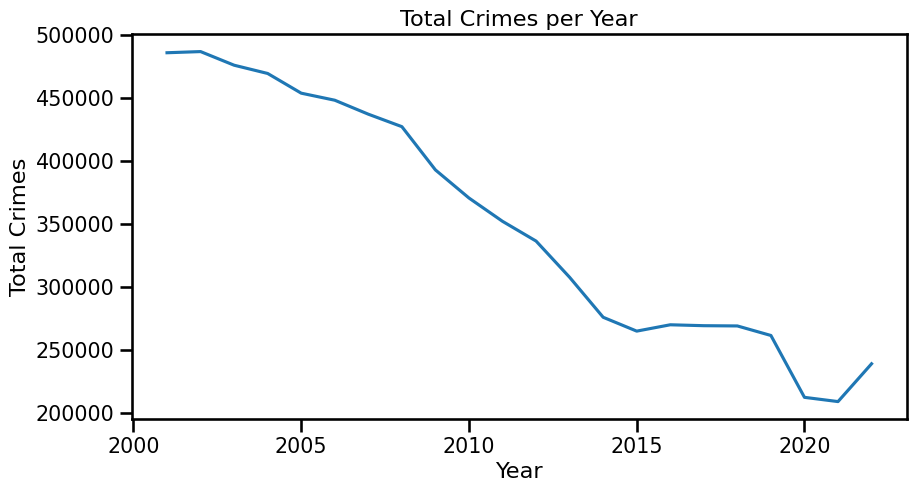

The total number of 'Crimes' is decreasing across the years.


In [39]:
# Group by year and count the number of occurrences for each 'Primary Type'
primary_type_counts_by_year = df.groupby(['year', 'Primary Type'])['Primary Type'].count().unstack()

# Calculate the total count for each year
total_counts_by_year = primary_type_counts_by_year.sum(axis=1)

# Plot the total counts over time
total_counts_by_year.plot(kind='line', figsize=(10, 5))
plt.xlabel('Year')
plt.ylabel('Total Crimes')
plt.title('Total Crimes per Year')
plt.show()

# Determine if the trend is increasing or decreasing
if total_counts_by_year.diff().sum() > 0:
  print("The total number of 'Crimes' is increasing across the years.")
elif total_counts_by_year.diff().sum() < 0:
  print("The total number of 'Crimes' is decreasing across the years.")
else:
  print("The total number of 'Crimes' remains relatively constant across the years.")


In [40]:
crime_count = df.groupby(['year', 'Primary Type']).size()

In [41]:
crime_count= crime_count.unstack(fill_value=0)
crime_count

Primary Type  ARSON  ASSAULT  BATTERY  BURGLARY  CONCEALED CARRY LICENSE VIOLATION  CRIMINAL DAMAGE  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  GAMBLING  HOMICIDE  HUMAN TRAFFICKING  INTERFERENCE WITH PUBLIC OFFICER  INTIMIDATION  KIDNAPPING  LIQUOR LAW VIOLATION  MOTOR VEHICLE THEFT  NARCOTICS  NON-CRIMINAL  OBSCENITY  OFFENSE INVOLVING CHILDREN  OTHER NARCOTIC VIOLATION  OTHER OFFENSE  PUBLIC INDECENCY  PUBLIC PEACE VIOLATION  RITUALISM  ROBBERY  STALKING  Sexual Crime  THEFT  WEAPONS VIOLATION
year                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2001           1011    31384    93461     26014                                  1            55859              13241               14949                  1       934       667                  0                               406           279         933                  1637                27553      50567             0         19                        2263                         6          29662                 9                    2750          8    18441       204         10073  99277               4277
2002           1032    31523    94153     25623                                  0            55941              13880               13732                  0       971       658                  0                               361           337         829                  1414                25121      51789             0         26                        2594                         5          32600                 8                    2457          2    18523       200         10415  98332               4281
2003            955    29477    88380     25157                                  0            55011              14807               13459                  0      1088       604                  0                               409           364         705                  1311                22748      54288             1         16                        3047                         2          31148                 6                    2430          2    17332       247          9904  98876               4211
2004            778    28850    87136     24564                                  0            53164              15913               13255                  0      1122       455                  0                               531           349         482                   985                22805      57060             0         13                        3099                         9          29532                 9                    2495          1    15978       215         10861  95463               4298
2005            691    27067    83964     25503                                  0            54548              16655               13590                  0      1078       453                  0                               615           258         389                  1005                22497      56234             0         19                        2906                         9          28028                 4                    2730          2    16047       192          9499  85684               4106
2006            726    25945    80666     24324                                  0            57124              14505               13606                  0      1368       476                  0                               758           276         339                  1135                21818      55813             0         17                        2783                  

In [42]:
crime_change = crime_count.diff().sum()
crime_change

Primary Type
ARSON                                 -590.0
ASSAULT                             -10588.0
BATTERY                             -52550.0
BURGLARY                            -18422.0
CONCEALED CARRY LICENSE VIOLATION      176.0
CRIMINAL DAMAGE                     -28618.0
CRIMINAL TRESPASS                    -9016.0
DECEPTIVE PRACTICE                    1456.0
DOMESTIC VIOLENCE                       -1.0
GAMBLING                              -925.0
HOMICIDE                                58.0
HUMAN TRAFFICKING                       17.0
INTERFERENCE WITH PUBLIC OFFICER       -14.0
INTIMIDATION                           -95.0
KIDNAPPING                            -816.0
LIQUOR LAW VIOLATION                 -1434.0
MOTOR VEHICLE THEFT                  -6104.0
NARCOTICS                           -45850.0
NON-CRIMINAL                             5.0
OBSCENITY                               30.0
OFFENSE INVOLVING CHILDREN            -384.0
OTHER NARCOTIC VIOLATION                 1.0
OTHER OFFENSE                       -15104.0
PUBLIC INDECENCY                        -4.0
PUBLIC PEACE VIOLATION               -2040.0
RITUALISM                               -8.0
ROBBERY                              -9476.0
STALKING                               242.0
Sexual Crime                         -7006.0
THEFT                               -44457.0
WEAPONS VIOLATION                     4489.0
dtype: float64

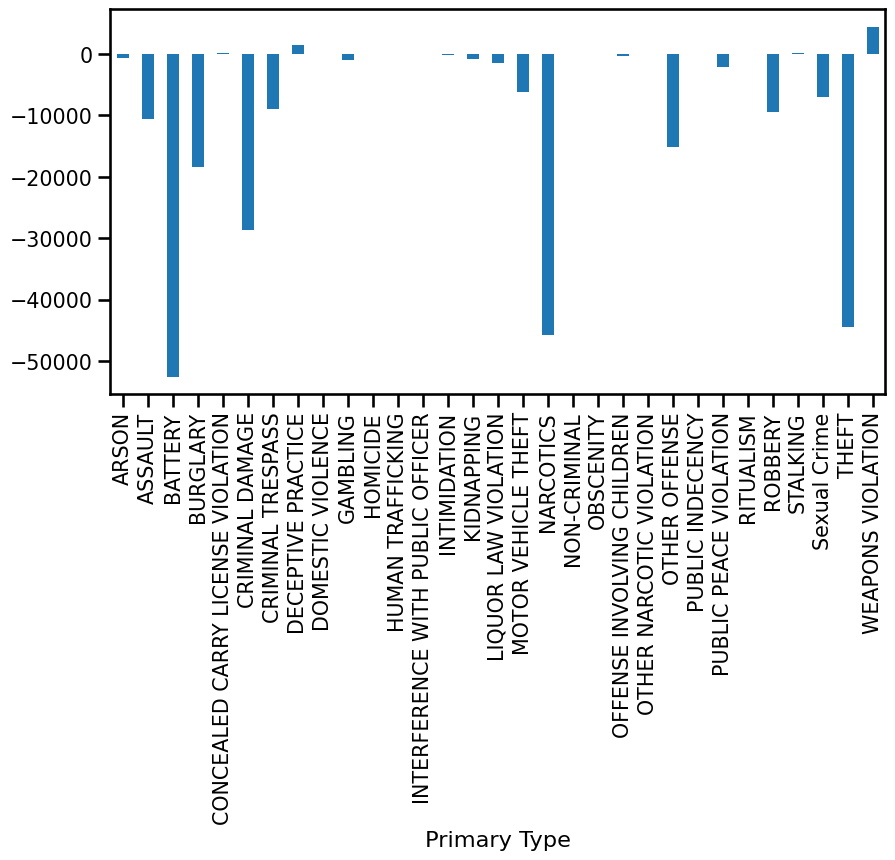

In [43]:
crime_change.plot(kind='bar',figsize=(10,5));

In [44]:
negative = crime_change > 0
negative_crimes = negative[negative == True]
negative_crimes

Primary Type
CONCEALED CARRY LICENSE VIOLATION    True
DECEPTIVE PRACTICE                   True
HOMICIDE                             True
HUMAN TRAFFICKING                    True
NON-CRIMINAL                         True
OBSCENITY                            True
OTHER NARCOTIC VIOLATION             True
STALKING                             True
WEAPONS VIOLATION                    True
dtype: bool

In [45]:
change_crimes = crime_change[negative_crimes.index]
change_crimes

Primary Type
CONCEALED CARRY LICENSE VIOLATION     176.0
DECEPTIVE PRACTICE                   1456.0
HOMICIDE                               58.0
HUMAN TRAFFICKING                      17.0
NON-CRIMINAL                            5.0
OBSCENITY                              30.0
OTHER NARCOTIC VIOLATION                1.0
STALKING                              242.0
WEAPONS VIOLATION                    4489.0
dtype: float64

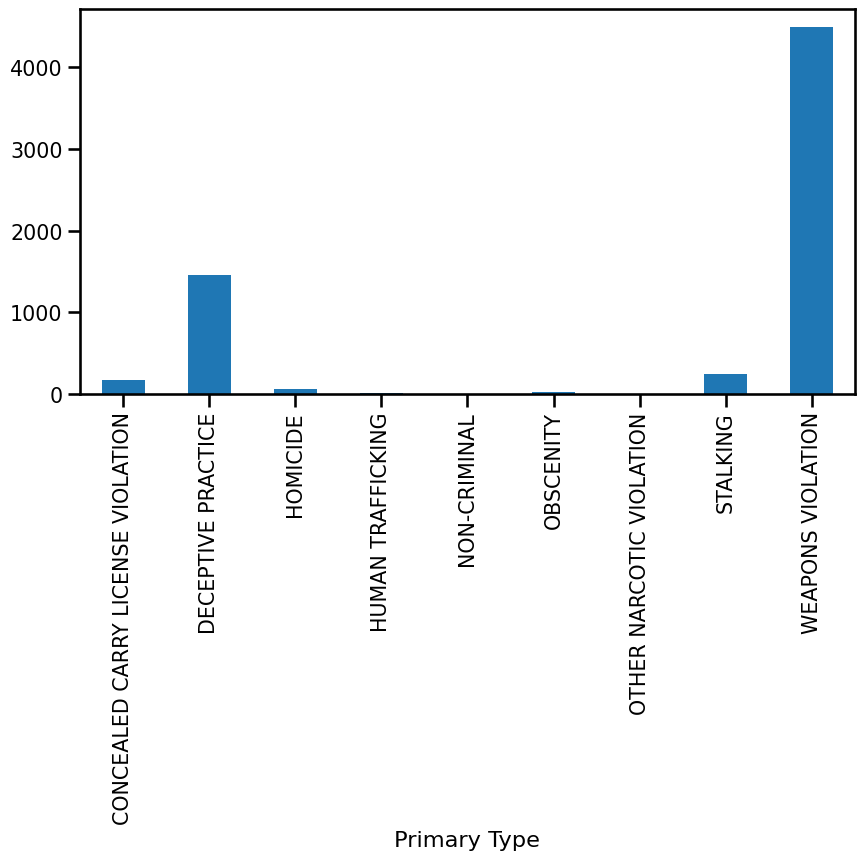

In [46]:
change_crimes.plot(kind='bar',figsize=(10,5));

In [47]:
print("Individual crimes with opposite trend to overall trend:")
for crime in change_crimes.index:
    print(f"- {crime}")

Individual crimes with opposite trend to overall trend:
- CONCEALED CARRY LICENSE VIOLATION
- DECEPTIVE PRACTICE
- HOMICIDE
- HUMAN TRAFFICKING
- NON-CRIMINAL
- OBSCENITY
- OTHER NARCOTIC VIOLATION
- STALKING
- WEAPONS VIOLATION


## Comparing AM vs. PM Rush Hour Crimes

In [48]:
df['hour'] = df.index.hour

In [49]:
df.head()


Primary Type          Description     Location Description  Arrest  Domestic  Beat  District AM/PM  year  hour
datetime                                                                                                                              
2001-01-01 01:00:00          BATTERY               SIMPLE                RESIDENCE   False     False  1624      16.0    AM  2001     1
2001-01-01 13:00:00          BATTERY               SIMPLE                RESIDENCE   False      True   825       8.0    PM  2001    13
2001-01-01 13:00:00         GAMBLING  ILLEGAL ILL LOTTERY                   STREET    True     False   313       3.0    PM  2001    13
2001-01-01 01:00:00  CRIMINAL DAMAGE           TO VEHICLE                   STREET   False     False  2424      24.0    AM  2001     1
2001-01-01 01:00:00          BATTERY               SIMPLE  RESIDENCE PORCH/HALLWAY   False      True   214       2.0    AM  2001     1

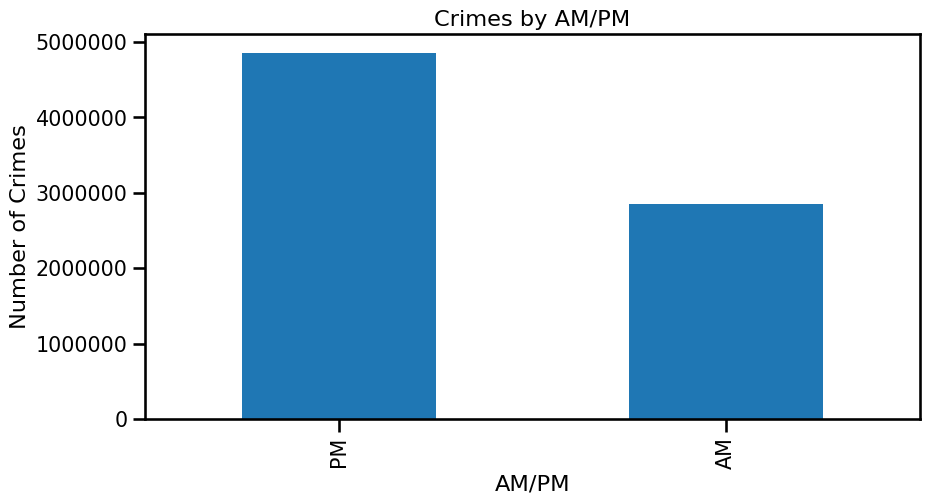

In [50]:
# Group by 'AM/PM' and count the number of occurrences
am_pm_counts = df['AM/PM'].value_counts()

# Plot the counts
am_pm_counts.plot(kind='bar', figsize=(10, 5))
plt.xlabel('AM/PM')
plt.ylabel('Number of Crimes')
plt.title('Crimes by AM/PM')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


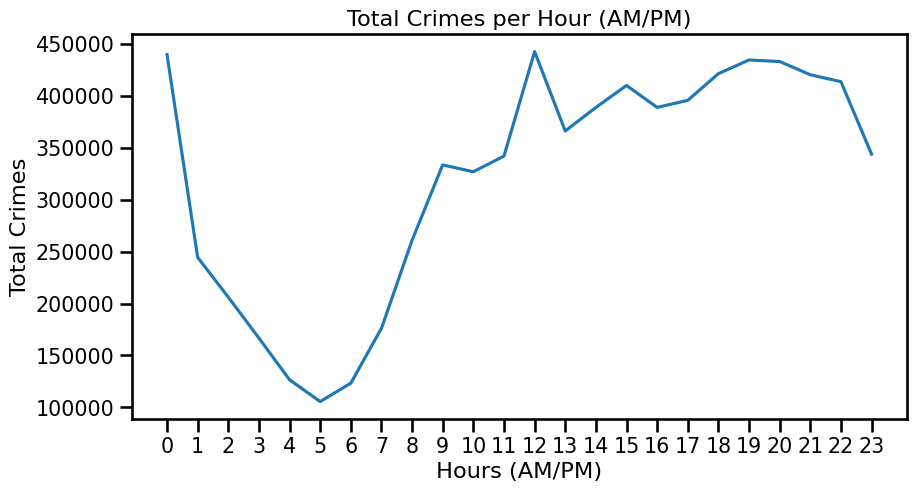

The total number of 'Crimes' is decreasing across the AM and increasing across the PM.


In [51]:
# Group by year and count the number of occurrences for each 'Primary Type'
primary_type_counts_by_hour = df.groupby(['hour', 'Primary Type'])['Primary Type'].count().unstack()

# Calculate the total count for each year
total_counts_by_hour = primary_type_counts_by_hour.sum(axis=1)

# Plot the total counts over time
total_counts_by_hour.plot(kind='line', figsize=(10, 5))
plt.xlabel('Hours (AM/PM)')
plt.ylabel('Total Crimes')
plt.xticks(range(24))
plt.title('Total Crimes per Hour (AM/PM)')
plt.show()

# Determine if the trend is increasing or decreasing
if total_counts_by_hour.diff().sum() > 0:
  print("The total number of 'Crimes' is increasing across the PM and decreasing across the AM .")
elif total_counts_by_hour.diff().sum() < 0:
  print("The total number of 'Crimes' is decreasing across the AM and increasing across the PM.")
else:
  print("The total number of 'Crimes' remains relatively constant across the day.")


## Top 10 most common crimes during AM/PM rush hour

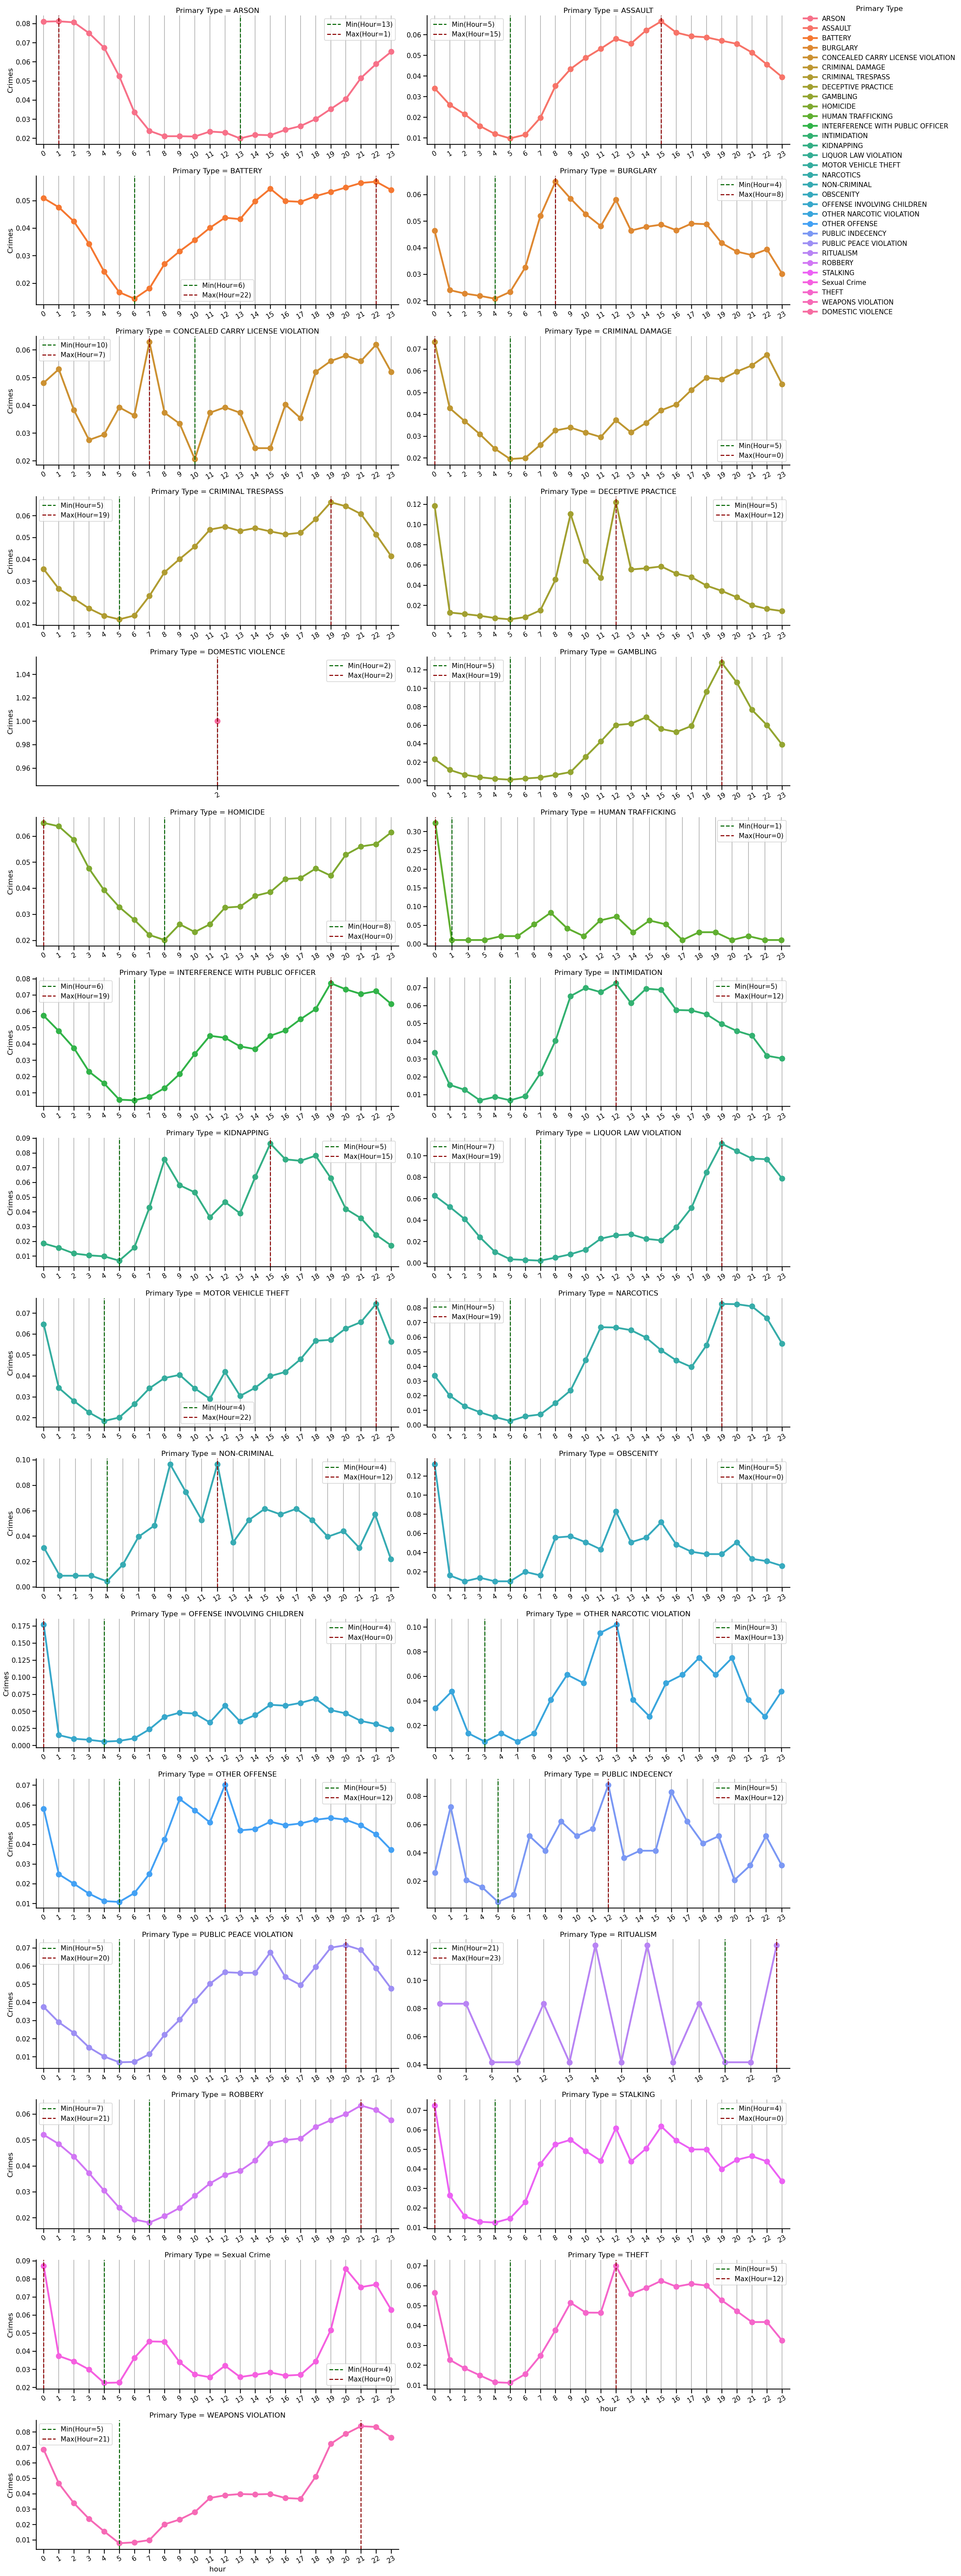

In [52]:
typebyhour =df.groupby("Primary Type")["hour"].value_counts(normalize=True).sort_index()

df_type = typebyhour.to_frame('Crimes').reset_index()

val_hour = df.groupby('Primary Type')['hour'].value_counts()

g = sns.catplot(data=df_type, x='hour', y='Crimes',
                hue='Primary Type', col='Primary Type', col_wrap=2,
                aspect=2, height=5,
                kind='point', sharey=False, sharex=False);

## loop throught the axes dict
for col, ax in g.axes_dict.items():

   ## Extract the idx min and idxmax from the val counts
   min_, max_ = val_hour.loc[col].agg(['idxmin','idxmax'])
   min_, max_ = str(min_), str(max_)
    ## add vlines for both and SAVE THE LINE and a label to use in legend
   ln1 =ax.axvline(min_, color='darkgreen',ls='--')
   lab1 = f'Min(Hour={min_})'

   ln2 = ax.axvline(max_,color='darkred',ls='--')
   lab2 = f'Max(Hour={max_})'

    ## manually add legend using list of ln1 and ln2 and a list of labels
   ax.legend( [ln1,ln2], [lab1,lab2])
    ## add x grid
ax.grid(axis='x')
for ax in g.axes.flat:
    ax.grid(axis='x') # add gridlines
    ax.tick_params(axis='x', rotation=30) # rotate x-axis labels
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.fig.tight_layout()

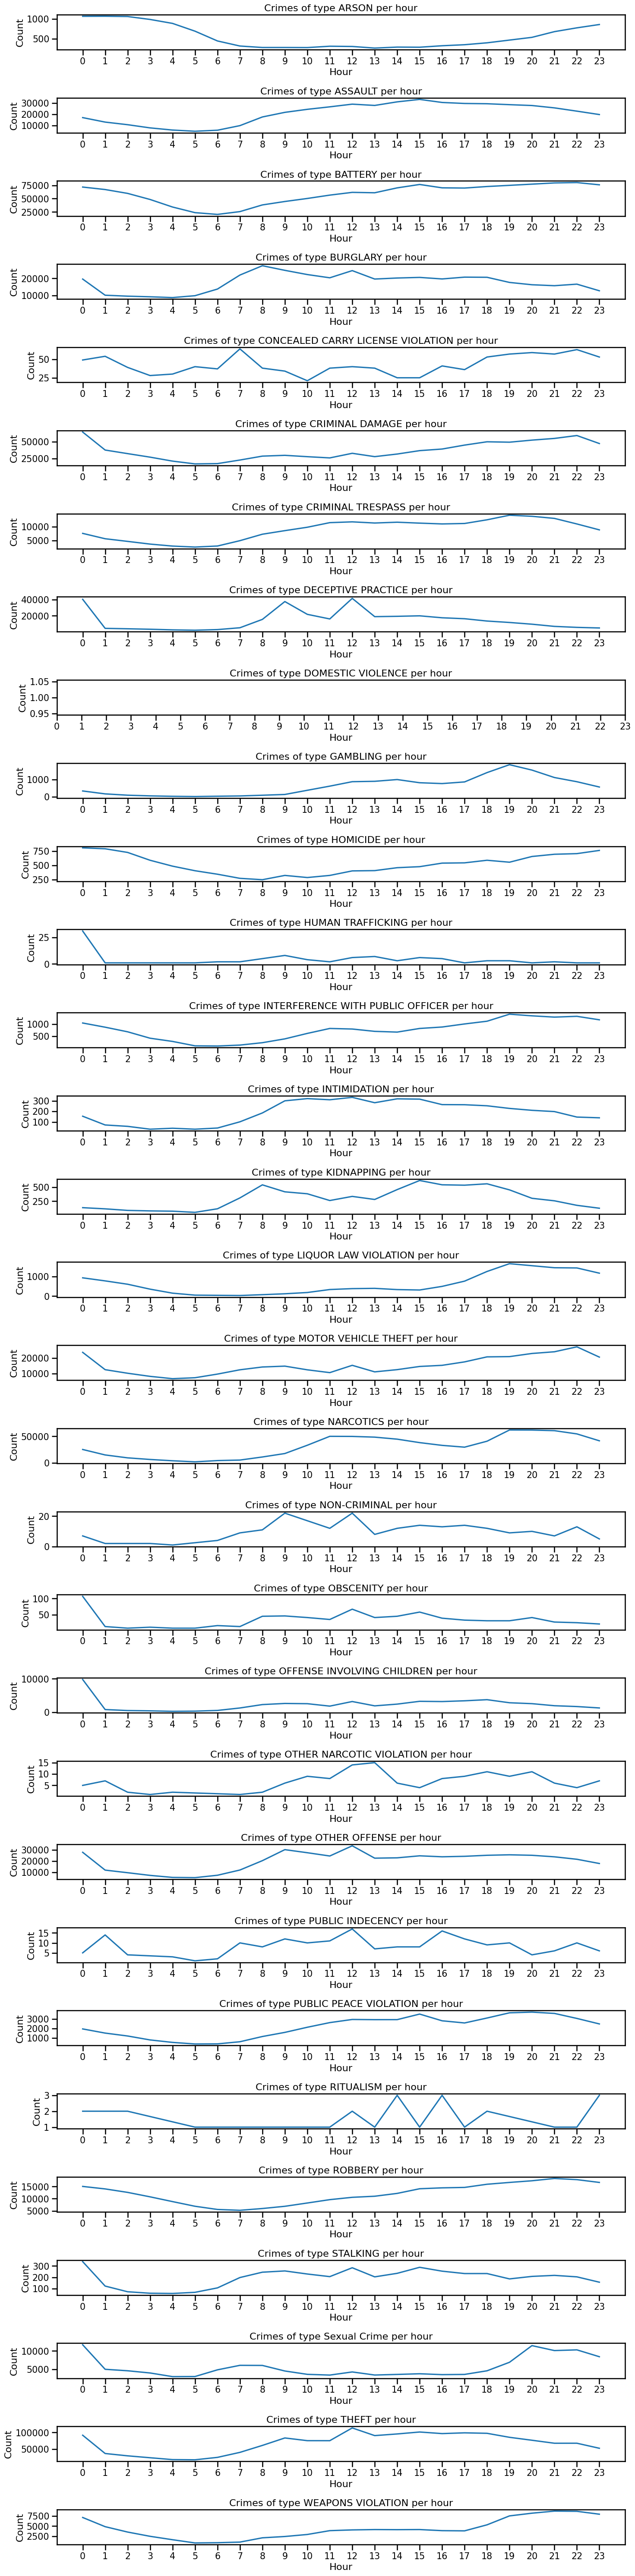

In [53]:
# Group by hour and 'Primary Type' and count occurrences
primary_type_counts_by_hour = df.groupby(['hour', 'Primary Type'])['Primary Type'].count().unstack()

# Get unique primary types
primary_types = primary_type_counts_by_hour.columns

# Create subplots for each primary type
fig, axes = plt.subplots(nrows=len(primary_types), ncols=1, figsize=(15, 60))

# Plot each primary type in a separate subplot
for i, primary_type in enumerate(primary_types):
  sns.lineplot(data=primary_type_counts_by_hour[primary_type], ax=axes[i])
  axes[i].set_xlabel('Hour')
  axes[i].set_ylabel('Count')
  axes[i].set_title(f'Crimes of type {primary_type} per hour')
  axes[i].set_xticks(range(24))

plt.tight_layout()
plt.show()


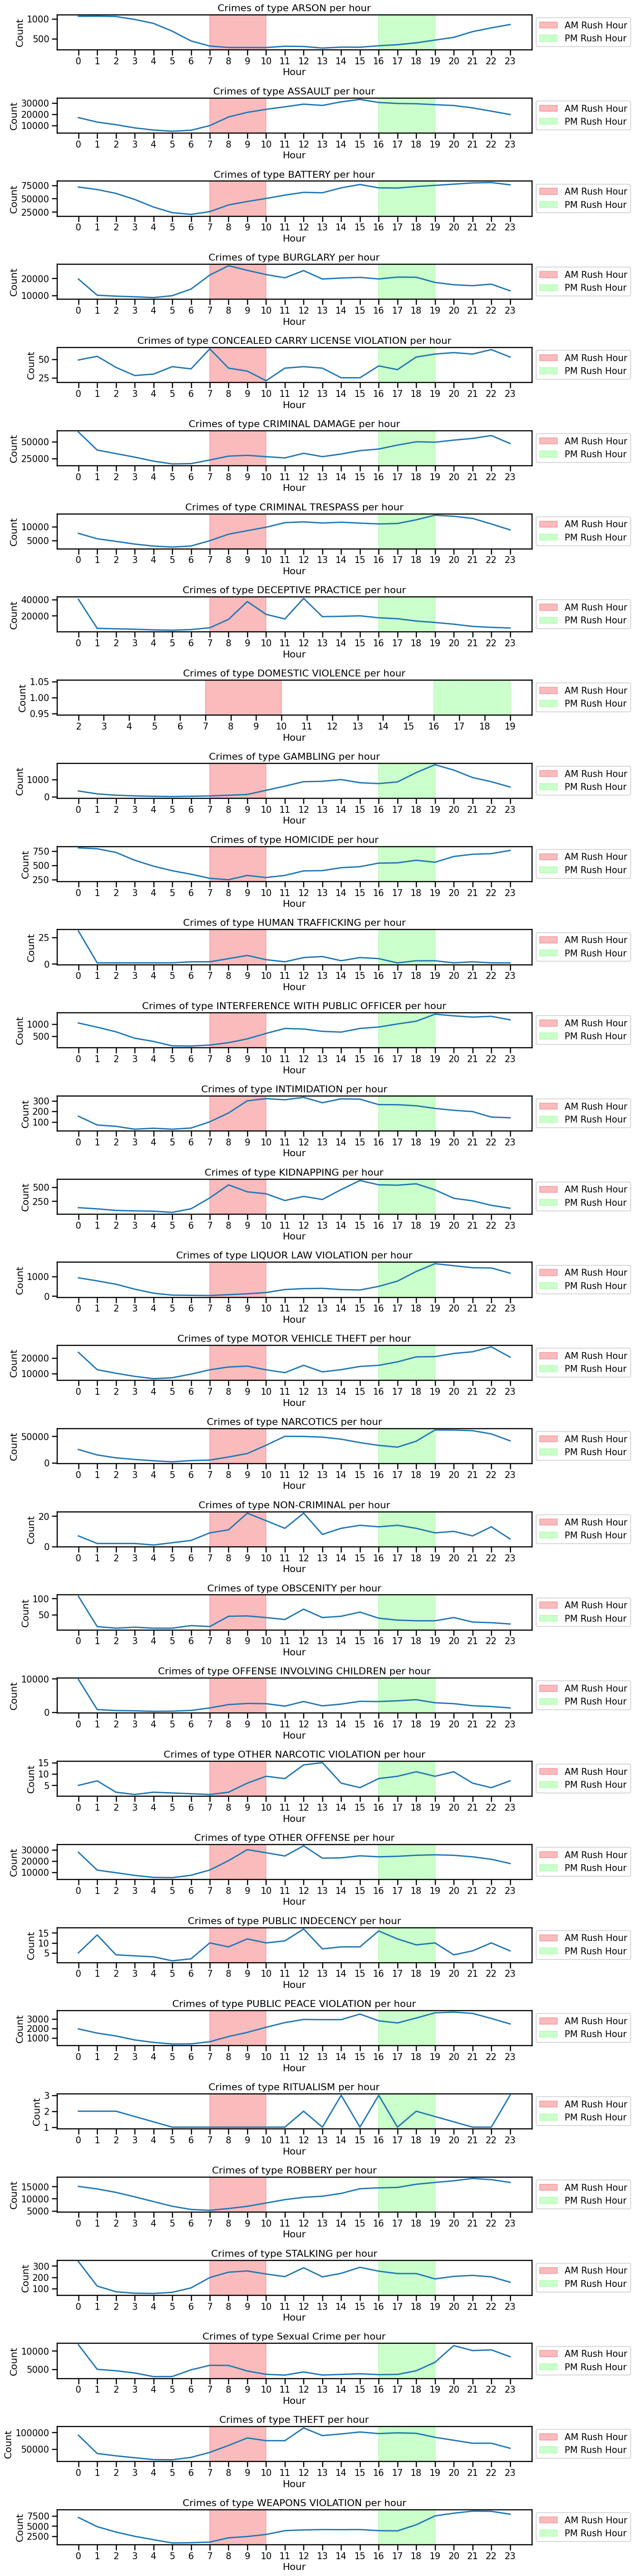

In [54]:
# Group by hour and 'Primary Type' and count occurrences
primary_type_counts_by_hour = df.groupby(['hour', 'Primary Type'])['Primary Type'].count().unstack()

# Get unique primary types
primary_types = primary_type_counts_by_hour.columns

# Create subplots for each primary type
fig, axes = plt.subplots(nrows=len(primary_types), ncols=1, figsize=(15, 60))

# Plot each primary type in a separate subplot
for i, primary_type in enumerate(primary_types):
  sns.lineplot(data=primary_type_counts_by_hour[primary_type], ax=axes[i])
  axes[i].set_xlabel('Hour')
  axes[i].set_ylabel('Count')
  axes[i].set_title(f'Crimes of type {primary_type} per hour')
  axes[i].set_xticks(range(24))

  # Add axvspan for AM rush hour
  axes[i].axvspan(7, 10, color='#f7797d', alpha=0.5, label='AM Rush Hour')

  # Add axvspan for PM rush hour
  axes[i].axvspan(16, 19, color='#98ff98', alpha=0.5, label='PM Rush Hour')

  # Move the legend outside the plot
  axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [55]:
# Group by hour and 'Primary Type' and count occurrences
primary_type_counts_by_hour = df.groupby(['hour', 'Primary Type'])['Primary Type'].count().unstack()

# Calculate the cumulative sum for each primary type
primary_type_counts_by_hour_cumsum = primary_type_counts_by_hour.cumsum()

# AM rush hour (7 AM to 10 AM)
am_rush_hour_cumsum = primary_type_counts_by_hour_cumsum.loc[7:10].sum()
top_10_am_rush_crimes = am_rush_hour_cumsum.sort_values(ascending=False).head(10)
print("Top 10 crimes during AM rush hour:")
print(top_10_am_rush_crimes)

# PM rush hour (4 PM to 7 PM)
pm_rush_hour_cumsum = primary_type_counts_by_hour_cumsum.loc[16:19].sum()
top_10_pm_rush_crimes = pm_rush_hour_cumsum.sort_values(ascending=False).head(10)
print("\nTop 10 crimes during PM rush hour:")
print(top_10_pm_rush_crimes)

# Compare the total cumulative sum of crimes in AM and PM rush hours
if am_rush_hour_cumsum.sum() > pm_rush_hour_cumsum.sum():
  print("\nThe cumulative sum of crimes is higher during AM rush hour.")
else:
  print("\nThe cumulative sum of crimes is higher during PM rush hour.")


Top 10 crimes during AM rush hour:
Primary Type
BATTERY                1656031.0
THEFT                  1567089.0
CRIMINAL DAMAGE        1134095.0
BURGLARY                565116.0
OTHER OFFENSE           493489.0
MOTOR VEHICLE THEFT     449108.0
ASSAULT                 421203.0
DECEPTIVE PRACTICE      401646.0
NARCOTICS               387383.0
ROBBERY                 356001.0
dtype: float64

Top 10 crimes during PM rush hour:
Primary Type
THEFT                  4896611.0
BATTERY                3950662.0
CRIMINAL DAMAGE        2367437.0
NARCOTICS              1817221.0
ASSAULT                1445800.0
OTHER OFFENSE          1412580.0
BURGLARY               1328906.0
DECEPTIVE PRACTICE     1178207.0
MOTOR VEHICLE THEFT     964371.0
ROBBERY                 780978.0
dtype: float64

The cumulative sum of crimes is higher during PM rush hour.


In [56]:
# Calculate the total sum of crimes for AM and PM rush hours
total_am_rush_crimes = am_rush_hour_cumsum.sum()
total_pm_rush_crimes = pm_rush_hour_cumsum.sum()

# Calculate the percentage of each crime in AM rush hour
am_rush_hour_percentages = (top_10_am_rush_crimes / total_am_rush_crimes) * 100

# Calculate the percentage of each crime in PM rush hour
pm_rush_hour_percentages = (top_10_pm_rush_crimes / total_pm_rush_crimes) * 100

print("Percentage of Top 10 crimes during AM rush hour:")
print(am_rush_hour_percentages)

print("\nPercentage of Top 10 crimes during PM rush hour:")
print(pm_rush_hour_percentages)


Percentage of Top 10 crimes during AM rush hour:
Primary Type
BATTERY                20.363677
THEFT                  19.269986
CRIMINAL DAMAGE        13.945599
BURGLARY                6.949048
OTHER OFFENSE           6.068274
MOTOR VEHICLE THEFT     5.522536
ASSAULT                 5.179397
DECEPTIVE PRACTICE      4.938911
NARCOTICS               4.763523
ROBBERY                 4.377629
dtype: float64

Percentage of Top 10 crimes during PM rush hour:
Primary Type
THEFT                  22.396085
BATTERY                18.069510
CRIMINAL DAMAGE        10.828167
NARCOTICS               8.311593
ASSAULT                 6.612790
OTHER OFFENSE           6.460848
BURGLARY                6.078141
DECEPTIVE PRACTICE      5.388875
MOTOR VEHICLE THEFT     4.410833
ROBBERY                 3.572032
dtype: float64


## Motor Vehicle Thefts

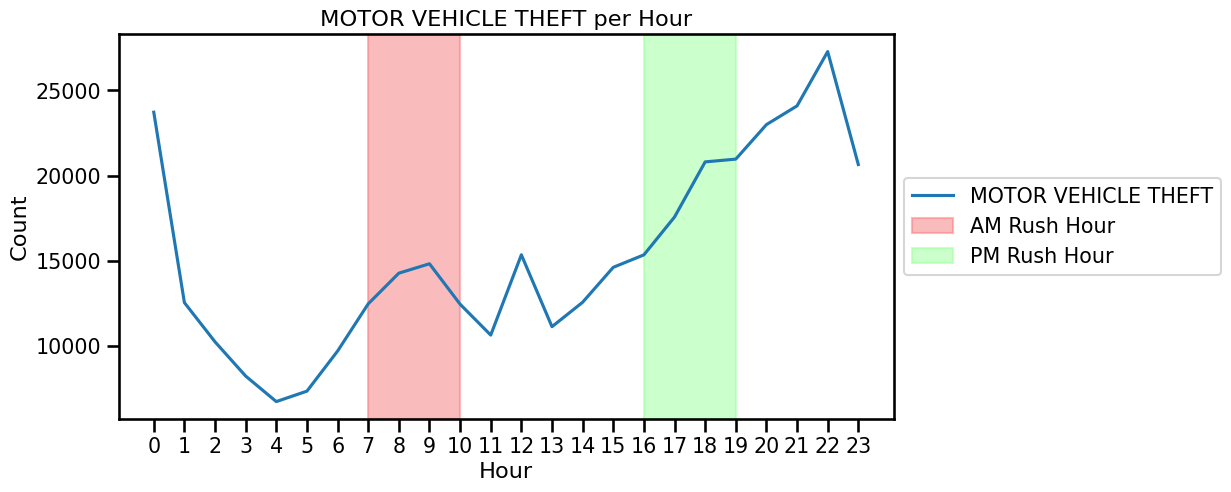

In [57]:
# Group by hour and 'Primary Type' and count occurrences
primary_type_counts_by_hour = df.groupby(['hour', 'Primary Type'])['Primary Type'].count().unstack()

# Select only 'MOTOR VEHICLE THEFT'
MOTOR_VEHICLE_THEFT_by_hour = primary_type_counts_by_hour['MOTOR VEHICLE THEFT']

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(10, 5)) # Create axes object here

# Plot the data
MOTOR_VEHICLE_THEFT_by_hour.plot(kind='line', ax=ax) # Pass the axes object to the plot function

# Add axvspan for AM rush hour
ax.axvspan(7, 10, color='#f7797d', alpha=0.5, label='AM Rush Hour') # Use 'ax' instead of 'axis'

# Add axvspan for PM rush hour
ax.axvspan(16, 19, color='#98ff98', alpha=0.5, label='PM Rush Hour') # Use 'ax' instead of 'axis'

# Move the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('MOTOR VEHICLE THEFT per Hour')
plt.xticks(range(24))
plt.show()


The cumulative sum of MOTOR VEHICLE THEFT is higher during PM rush hour.


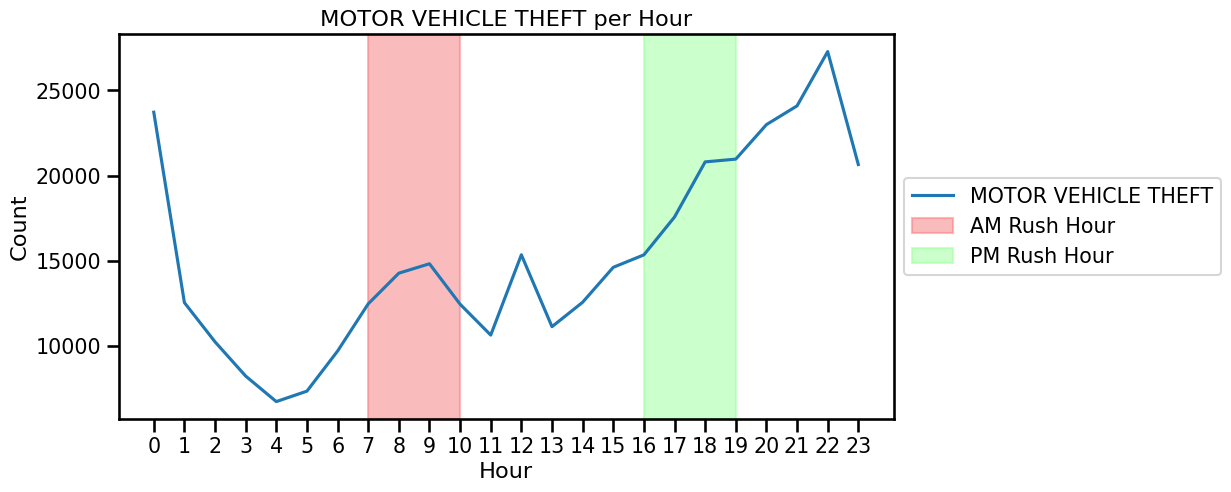

In [58]:
# Group by hour and 'Primary Type' and count occurrences
primary_type_counts_by_hour = df.groupby(['hour', 'Primary Type'])['Primary Type'].count().unstack()

# Select only 'MOTOR VEHICLE THEFT'
MOTOR_VEHICLE_THEFT_by_hour = primary_type_counts_by_hour['MOTOR VEHICLE THEFT']

# Calculate the cumulative sum
MOTOR_VEHICLE_THEFT_by_hour_cumsum = MOTOR_VEHICLE_THEFT_by_hour.cumsum()

# AM rush hour (7 AM to 10 AM)
am_rush_hour_cumsum_motor_vehicle_theft = MOTOR_VEHICLE_THEFT_by_hour_cumsum.loc[7:10].sum()

# PM rush hour (4 PM to 7 PM)
pm_rush_hour_cumsum_motor_vehicle_theft = MOTOR_VEHICLE_THEFT_by_hour_cumsum.loc[16:19].sum()

# Compare the total cumulative sum of crimes in AM and PM rush hours
if am_rush_hour_cumsum_motor_vehicle_theft > pm_rush_hour_cumsum_motor_vehicle_theft:
  print("\nThe cumulative sum of MOTOR VEHICLE THEFT is higher during AM rush hour.")
else:
  print("\nThe cumulative sum of MOTOR VEHICLE THEFT is higher during PM rush hour.")

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the data
MOTOR_VEHICLE_THEFT_by_hour.plot(kind='line', ax=ax)

# Add axvspan for AM rush hour
ax.axvspan(7, 10, color='#f7797d', alpha=0.5, label='AM Rush Hour')

# Add axvspan for PM rush hour
ax.axvspan(16, 19, color='#98ff98', alpha=0.5, label='PM Rush Hour')

# Move the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('MOTOR VEHICLE THEFT per Hour')
plt.xticks(range(24))
plt.show()

## Comparing Months

In [59]:
# Extract month from datetime index
df['month'] = df.index.month

# Group by month and count the number of occurrences for each 'Primary Type'
primary_type_counts_by_month = df.groupby(['month', 'Primary Type'])['Primary Type'].count().unstack()

# Calculate the total count for each month
total_counts_by_month = primary_type_counts_by_month.sum(axis=1)

# Find the month with the most crimes
max_month = total_counts_by_month.idxmax()
max_value = total_counts_by_month.max()
print(f"Month with the most crimes: {max_month} with {max_value} crimes")

# Find the month with the least crimes
min_month = total_counts_by_month.idxmin()
min_value = total_counts_by_month.min()
print(f"Month with the least crimes: {min_month} with {min_value} crimes")

Month with the most crimes: 7 with 717232.0 crimes
Month with the least crimes: 2 with 529391.0 crimes


In [60]:
# Calculate the change in crime counts for each primary type across months
crime_change_by_month = primary_type_counts_by_month.diff().sum()

# Identify crimes with opposite trend to overall trend
negative = crime_change_by_month > 0
negative_crimes = negative[negative == True]
change_crimes = crime_change_by_month[negative_crimes.index]

print("Individual crimes with opposite trend to overall trend:")
for crime in change_crimes.index:
    print(f"- {crime}")

Individual crimes with opposite trend to overall trend:
- ARSON
- BURGLARY
- CONCEALED CARRY LICENSE VIOLATION
- CRIMINAL DAMAGE
- HOMICIDE
- MOTOR VEHICLE THEFT
- NON-CRIMINAL
- PUBLIC INDECENCY
- ROBBERY
- THEFT


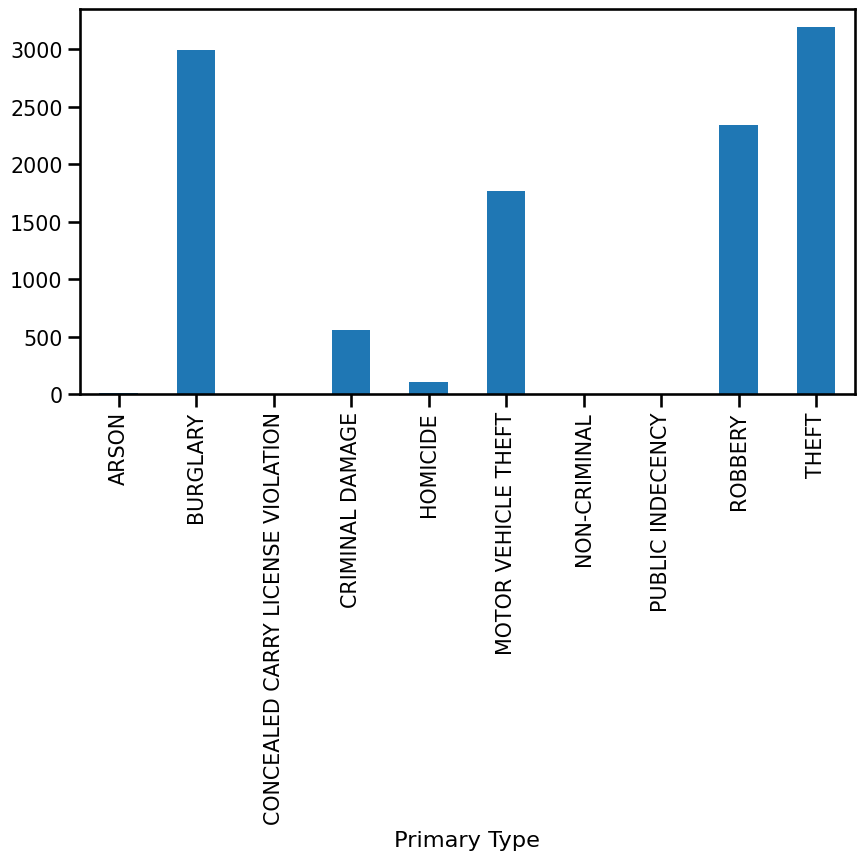

In [61]:
change_crimes.plot(kind='bar',figsize=(10,5));

## Comparing Holidays

In [62]:
#!pip install holidays

In [63]:
import holidays
import datetime as dt
from holidays import country_holidays

In [64]:
df.head()

Primary Type          Description     Location Description  Arrest  Domestic  Beat  District AM/PM  year  hour  month
datetime                                                                                                                                     
2001-01-01 01:00:00          BATTERY               SIMPLE                RESIDENCE   False     False  1624      16.0    AM  2001     1      1
2001-01-01 13:00:00          BATTERY               SIMPLE                RESIDENCE   False      True   825       8.0    PM  2001    13      1
2001-01-01 13:00:00         GAMBLING  ILLEGAL ILL LOTTERY                   STREET    True     False   313       3.0    PM  2001    13      1
2001-01-01 01:00:00  CRIMINAL DAMAGE           TO VEHICLE                   STREET   False     False  2424      24.0    AM  2001     1      1
2001-01-01 01:00:00          BATTERY               SIMPLE  RESIDENCE PORCH/HALLWAY   False      True   214       2.0    AM  2001     1      1

In [65]:
all_days = pd.date_range(df.index.min(), df.index.max())
all_days

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04', '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08', '2001-01-09', '2001-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31'], dtype='datetime64[ns]', length=8035, freq='D')

In [66]:
us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

In [67]:
print(all_days[0])
us_holidays.get(all_days[0])

2001-01-01 00:00:00


"New Year's Day"

In [68]:
holiday_list = [us_holidays.get(day) for day in all_days]
holiday_list[:5]

["New Year's Day", None, None, None, None]

In [69]:
IL_holidays = country_holidays('US', subdiv='IL')
IL_holidays

holidays.country_holidays('US', subdiv='IL')

In [70]:
IL_holidays_list = [IL_holidays.get(day) for day in all_days]
IL_holidays_list[:3]

["New Year's Day", None, None]

In [71]:
## Saving both holiday types as columns
df["US Holiday"] = [us_holidays.get(day) for day in df.index]
df['IL Holidays'] = [IL_holidays.get(day) for day in df.index]

In [72]:
df.head()

Primary Type          Description     Location Description  Arrest  Domestic  Beat  District AM/PM  year  hour  month      US Holiday     IL Holidays
datetime                                                                                                                                                                     
2001-01-01 01:00:00          BATTERY               SIMPLE                RESIDENCE   False     False  1624      16.0    AM  2001     1      1  New Year's Day  New Year's Day
2001-01-01 13:00:00          BATTERY               SIMPLE                RESIDENCE   False      True   825       8.0    PM  2001    13      1  New Year's Day  New Year's Day
2001-01-01 13:00:00         GAMBLING  ILLEGAL ILL LOTTERY                   STREET    True     False   313       3.0    PM  2001    13      1  New Year's Day  New Year's Day
2001-01-01 01:00:00  CRIMINAL DAMAGE           TO VEHICLE                   STREET   False     False  2424      24.0    AM  2001     1      1  New Year's Day  New Year's Day
2001-01-01 01:00:00          BATTERY               SIMPLE  RESIDENCE PORCH/HALLWAY   False      True   214       2.0    AM  2001     1      1  New Year's Day  New Year's Day

In [73]:
df['US Holiday'].value_counts()

US Holiday
New Year's Day                                     32725
Independence Day                                   22672
Labor Day                                          22164
Memorial Day                                       21125
Columbus Day                                       20920
Veterans Day                                       20418
Martin Luther King Jr. Day                         17916
Washington's Birthday                              17597
Thanksgiving                                       14798
Christmas Day                                      12418
Independence Day (observed)                         5884
Veterans Day (observed)                             5842
Christmas Day (observed)                            4929
New Year's Day (observed)                           4877
Juneteenth National Independence Day                1450
Juneteenth National Independence Day (observed)     1403
Name: count, dtype: int64

In [74]:
df['IL Holidays'].value_counts()

IL Holidays
New Year's Day                                     32725
Independence Day                                   22672
Labor Day                                          22164
Memorial Day                                       21125
Columbus Day                                       20920
Veterans Day                                       20418
Casimir Pulaski Day                                19128
Lincoln's Birthday                                 18165
Martin Luther King Jr. Day                         17916
Washington's Birthday                              17597
Thanksgiving                                       14798
Christmas Day                                      12418
Election Day                                        6342
Independence Day (observed)                         5884
Veterans Day (observed)                             5842
Lincoln's Birthday (observed)                       5156
Christmas Day (observed)                            4929
New Year's Day (observed)                           4877
Juneteenth National Independence Day                1450
Juneteenth National Independence Day (observed)     1403
Name: count, dtype: int64

In [75]:
holiday_counts_us = df.groupby('US Holiday')['US Holiday'].count()

top_3_holidays_us = holiday_counts_us.sort_values(ascending=False).head(3)

print("Top 3 holidays with the largest number of crimes:")
print(top_3_holidays_us)

Top 3 holidays with the largest number of crimes:
US Holiday
New Year's Day      32725
Independence Day    22672
Labor Day           22164
Name: US Holiday, dtype: int64


In [76]:
# Get the top 3 holidays with the most crime
top_3_holidays_us = df.groupby('US Holiday')['US Holiday'].count().sort_values(ascending=False).head(3).index

# Iterate through the top 3 holidays
for holiday in top_3_holidays_us:
  # Filter the DataFrame for the current holiday
  holiday_df = df[df['US Holiday'] == holiday]

  # Get the top 5 most common crimes on that holiday
  top_5_crimes = holiday_df['Primary Type'].value_counts().head(5)

  print(f"\nTop 5 crimes on {holiday}:")
  display(top_5_crimes)



Top 5 crimes on New Year's Day:


Primary Type
THEFT                         6845
BATTERY                       6043
CRIMINAL DAMAGE               3236
DECEPTIVE PRACTICE            2934
OFFENSE INVOLVING CHILDREN    2380
Name: count, dtype: int64


Top 5 crimes on Independence Day:


Primary Type
BATTERY            5805
THEFT              4074
CRIMINAL DAMAGE    3309
ASSAULT            1547
NARCOTICS          1522
Name: count, dtype: int64


Top 5 crimes on Labor Day:


Primary Type
BATTERY            4607
THEFT              4520
CRIMINAL DAMAGE    2475
NARCOTICS          2078
ASSAULT            1525
Name: count, dtype: int64

## Cycles (Seasonality)

In [77]:
crimes_ts = df.pivot_table(index='datetime', columns='Primary Type', aggfunc='size', fill_value=0)

In [78]:
crimes_ts.head()

Primary Type         ARSON  ASSAULT  BATTERY  BURGLARY  CONCEALED CARRY LICENSE VIOLATION  CRIMINAL DAMAGE  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  GAMBLING  HOMICIDE  HUMAN TRAFFICKING  INTERFERENCE WITH PUBLIC OFFICER  INTIMIDATION  KIDNAPPING  LIQUOR LAW VIOLATION  MOTOR VEHICLE THEFT  NARCOTICS  NON-CRIMINAL  OBSCENITY  OFFENSE INVOLVING CHILDREN  OTHER NARCOTIC VIOLATION  OTHER OFFENSE  PUBLIC INDECENCY  PUBLIC PEACE VIOLATION  RITUALISM  ROBBERY  STALKING  Sexual Crime  THEFT  WEAPONS VIOLATION
datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2001-01-01 00:00:00      0        2        1         1                                  0               12                  0                  16                  0         0         0                  0                                 0             0           0                     0                    0          0             0          0                          30                         0              8                 0                       0          0        0         0            52     71                  0
2001-01-01 00:01:00      0        0        1         1                                  0                7                  0                  18                  0         0         0                  0                                 0             0           0                     0                    4          0             0          0                          36                         0              4                 0                       0          0        0         0            22     49                  0
2001-01-01 00:04:00      0        0        0         0                                  0                0                  0                   0                  0         0         0                  0                                 0             0           0                     0                    0          0             0          0                           0                         0              0                 0                       0          0        0         0             0      0                  1
2001-01-01 00:05:00      0        0        2         0                                  0                3                  1                   0                  0         0         0                  0                                 0             0           0                     0                    3          0             0          0                           1                         0              0                 0                       0          0        0         0             0      0                  3
2001-01-01 00:07:00      0        0        0         0                                  0                1                  0                   0                  0         0         0                  0                                 0             0           0                     0                    0          0             0          0                           0                         0              0                 0                       0          0        0         0             0      0                  0

In [79]:
crimes_ts_month = crimes_ts.resample('M').sum()

In [80]:
crimes_ts_month.head()

Primary Type  ARSON  ASSAULT  BATTERY  BURGLARY  CONCEALED CARRY LICENSE VIOLATION  CRIMINAL DAMAGE  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  GAMBLING  HOMICIDE  HUMAN TRAFFICKING  INTERFERENCE WITH PUBLIC OFFICER  INTIMIDATION  KIDNAPPING  LIQUOR LAW VIOLATION  MOTOR VEHICLE THEFT  NARCOTICS  NON-CRIMINAL  OBSCENITY  OFFENSE INVOLVING CHILDREN  OTHER NARCOTIC VIOLATION  OTHER OFFENSE  PUBLIC INDECENCY  PUBLIC PEACE VIOLATION  RITUALISM  ROBBERY  STALKING  Sexual Crime  THEFT  WEAPONS VIOLATION
datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2001-01-31       67     2123     6527      1934                                  0             3966               1192                1398                  1        44        42                  0                                36            18          75                   101                 2097       4714             0          2                         246                         1           2800                 0                     161          2     1396        26           946   7867                337
2001-02-28       57     2029     6042      1666                                  0             3665               1063                1163                  0        37        27                  0                                27            24          57                   109                 1785       4369             0          1                         152                         0           2488                 1                     173          0     1159        13           710   6669                301
2001-03-31       93     2824     7662      1832                                  0             4617               1141                1313                  0        55        37                  0                                22            22          72                   147                 2151       4862             0          2                         195                         0           2836                 0                     267          2     1399        17           887   7766                345
2001-04-30       89     2746     8328      1932                                  0             4922               1133                1199                  0        79        59                  0                                34            21          49                   164                 2120       4044             0          2                         196                         0           2483                 1                     229          1     1341        29           867   7702                321
2001-05-31       94     2903     8887      1997                                  1             4757               1067                1261                  0        94        42                  0                                41            25          56                   194                 2197       4038             0          1                         213                         2           2528                 1                     239          1     1491        12           887   8420                390

In [81]:
total_crime_count = crimes_ts_month.sum(axis=1)

In [82]:
total_crime_count.head()

datetime
2001-01-31    38119
2001-02-28    33787
2001-03-31    40566
2001-04-30    40091
2001-05-31    41839
Freq: M, dtype: int64

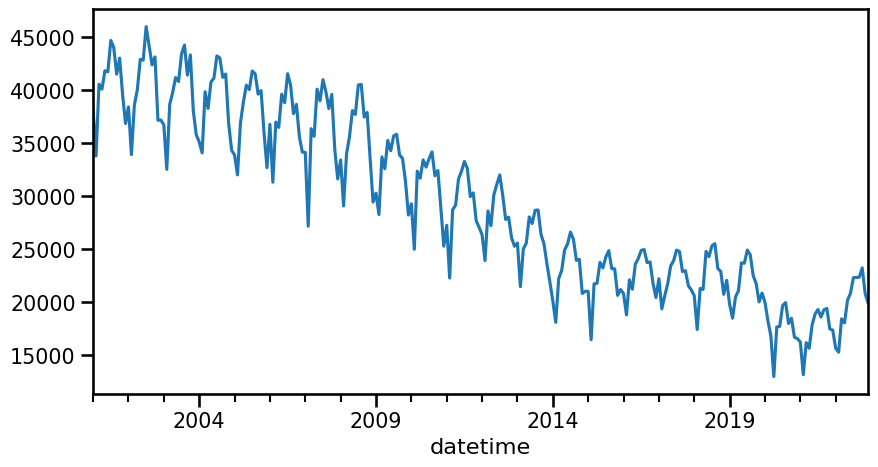

In [83]:
total_crime_count.plot(kind='line',figsize=(10,5));

In [84]:
total_crime_count['2014':'2020'].idxmax()

Timestamp('2014-07-31 00:00:00')

In [85]:
decomp_crime_count = tsa.seasonal_decompose(total_crime_count)

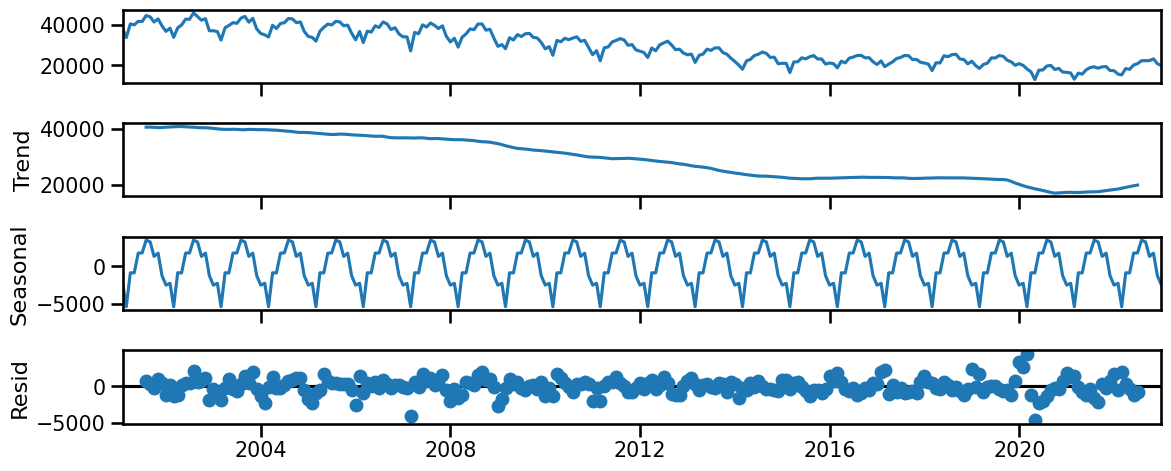

In [86]:
fig = decomp_crime_count.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [87]:
season= decomp_crime_count.seasonal['2014':'2020']
max_s = season.max()
min_s = season.min()
magnitude = max_s  - min_s
max_ids = season.idxmax()
min_ids = season.idxmin()

In [88]:
def plot_seasonal(seasonal):
    minor_loc = mdates.MonthLocator()
    fig, ax = plt.subplots()
    ax.plot(seasonal)
    ax.set(title=f'Seasonal Component for crimes');
    ax.xaxis.set_minor_locator(minor_loc)
    ax.grid(which='major', axis='x',lw=1, color='k')
    ax.grid(which='minor',axis='x',lw=0.5)
    fig.autofmt_xdate(rotation=90, ha='center')

    return fig, ax

In [89]:
peaks, props = find_peaks(season, height=season.max())
peak_dates = season.index[peaks]
period = peak_dates[1] - peak_dates[0]

periods = []
for i in range(len(peak_dates)-1):
    delta = peak_dates[i+1] - peak_dates[i]
    periods.append(delta)
periods

[Timedelta('365 days 00:00:00'),
 Timedelta('366 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('366 days 00:00:00')]

Highest crime count was 3481.66 over the average on 2014-07-31 00:00:00,
 and the lowest was -5416.09 under the average on  2014-02-28 00:00:00,
 with a magnitude of 8897.74 over a period of 153 days 00:00:00, 
 this data is represented on a monthly scale.


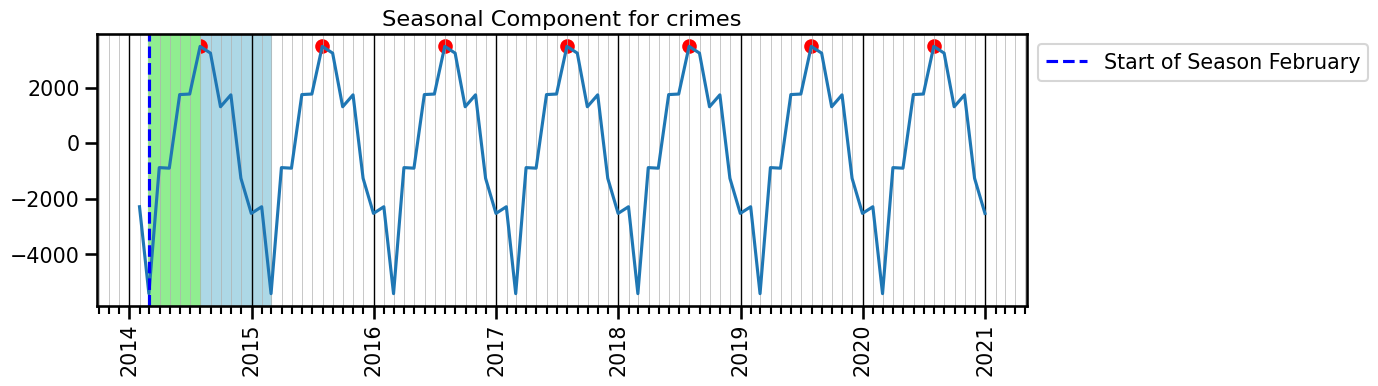

In [90]:
fig, ax = plot_seasonal(season)
season_start = season.idxmin()
ax.axvspan( season_start, season_start +period, color='lightblue')
ax.axvline(season_start, color='blue', ls='--',
           label=f"Start of Season {season_start.strftime('%B')}")
ax.scatter(peak_dates, props['peak_heights'], color='red')
ax.axvspan(season.idxmin(),season.idxmax(), color='lightgreen')
ax.legend(bbox_to_anchor=(1,1));


print(f"Highest crime count was {max_s:.2f} over the average on {max_ids},\n and the lowest was {min_s:.2f} under the average on  {min_ids},\n with a magnitude of {magnitude:.2f} over a period of {max_ids - min_ids}, \n this data is represented on a monthly scale.")

# Sarima Model

## Imports

In [91]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00


In [92]:
import pmdarima as pm
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

### Custom Functions

In [93]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

In [94]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [95]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [96]:
def get_sig_lags(ts, type='ACF',  nlags=None,alpha=0.5):


    if type == 'ACF':
        # Running the function used by plot_acf
        corr_values, conf_int = tsa.stattools.acf(ts, alpha=alpha, nlags=nlags)

    elif type=='PACF':
        corr_values, conf_int = tsa.stattools.pacf(ts, alpha=alpha, nlags=nlags)

    else:
        raise Exception("type must be either 'ACF' or 'PACF'")

    # Determine lags
    lags =range(len(corr_values))

    # Create a centered version of the acf_df
    corr_df = pd.DataFrame({type:corr_values,
                            'Lags':lags,
                            'lower ci': conf_int[:,0]-corr_values, # subtract acf from lower ci to center
                            'upper ci': conf_int[:,1]-corr_values, # subtact acf to upper ci to center
                                 })
    corr_df = corr_df.set_index("Lags")

    # Getting filter for sig lags
    filter_sig_lags = (corr_df[type] < corr_df['lower ci']) | (corr_df[type] > corr_df['upper ci'])

    # Get lag #'s
    sig_lags= corr_df.index[filter_sig_lags]
    sig_lags = sig_lags[sig_lags!=0]

    return sig_lags

In [97]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)


    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

## Theft Modeling

### Data Inspection

In [98]:
crimes_ts_month.head()

Primary Type  ARSON  ASSAULT  BATTERY  BURGLARY  CONCEALED CARRY LICENSE VIOLATION  CRIMINAL DAMAGE  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  GAMBLING  HOMICIDE  HUMAN TRAFFICKING  INTERFERENCE WITH PUBLIC OFFICER  INTIMIDATION  KIDNAPPING  LIQUOR LAW VIOLATION  MOTOR VEHICLE THEFT  NARCOTICS  NON-CRIMINAL  OBSCENITY  OFFENSE INVOLVING CHILDREN  OTHER NARCOTIC VIOLATION  OTHER OFFENSE  PUBLIC INDECENCY  PUBLIC PEACE VIOLATION  RITUALISM  ROBBERY  STALKING  Sexual Crime  THEFT  WEAPONS VIOLATION
datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2001-01-31       67     2123     6527      1934                                  0             3966               1192                1398                  1        44        42                  0                                36            18          75                   101                 2097       4714             0          2                         246                         1           2800                 0                     161          2     1396        26           946   7867                337
2001-02-28       57     2029     6042      1666                                  0             3665               1063                1163                  0        37        27                  0                                27            24          57                   109                 1785       4369             0          1                         152                         0           2488                 1                     173          0     1159        13           710   6669                301
2001-03-31       93     2824     7662      1832                                  0             4617               1141                1313                  0        55        37                  0                                22            22          72                   147                 2151       4862             0          2                         195                         0           2836                 0                     267          2     1399        17           887   7766                345
2001-04-30       89     2746     8328      1932                                  0             4922               1133                1199                  0        79        59                  0                                34            21          49                   164                 2120       4044             0          2                         196                         0           2483                 1                     229          1     1341        29           867   7702                321
2001-05-31       94     2903     8887      1997                                  1             4757               1067                1261                  0        94        42                  0                                41            25          56                   194                 2197       4038             0          1                         213                         2           2528                 1                     239          1     1491        12           887   8420                390

In [99]:
crimes_ts_month['THEFT'].head()

datetime
2001-01-31    7867
2001-02-28    6669
2001-03-31    7766
2001-04-30    7702
2001-05-31    8420
Freq: M, Name: THEFT, dtype: int64

In [100]:
crimes_ts_month['THEFT'].isna().sum()

0

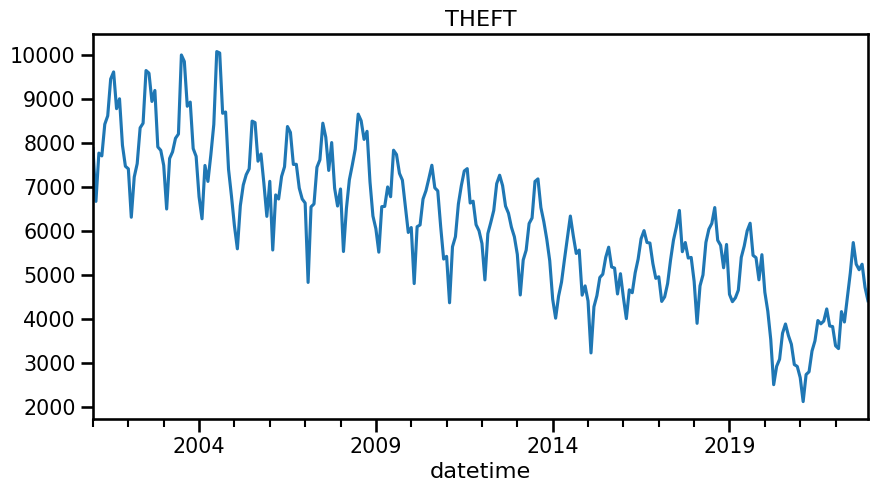

In [101]:
crimes_ts_month['THEFT'].plot(kind='line',figsize=(10,5),title='THEFT');

### Theft Seasonal Decompose

In [102]:
ts = crimes_ts_month['THEFT']

In [103]:
decomp = tsa.seasonal_decompose(ts)

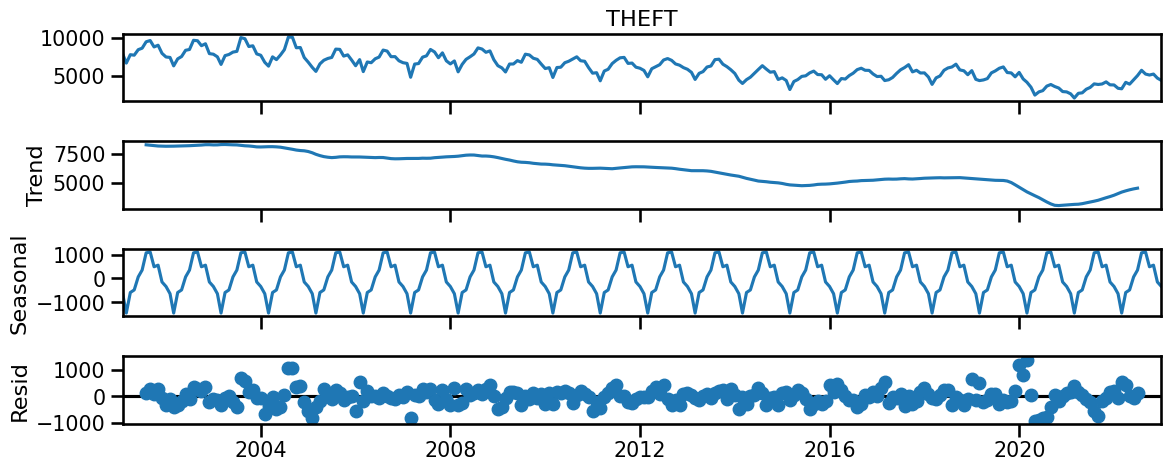

In [104]:
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [105]:
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

In [106]:
print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is  2549.99 which is ~32.08% of the variation in time series.


In [107]:
ts.index.min()

Timestamp('2001-01-31 00:00:00')

In [108]:
ts.index.max()

Timestamp('2022-12-31 00:00:00')

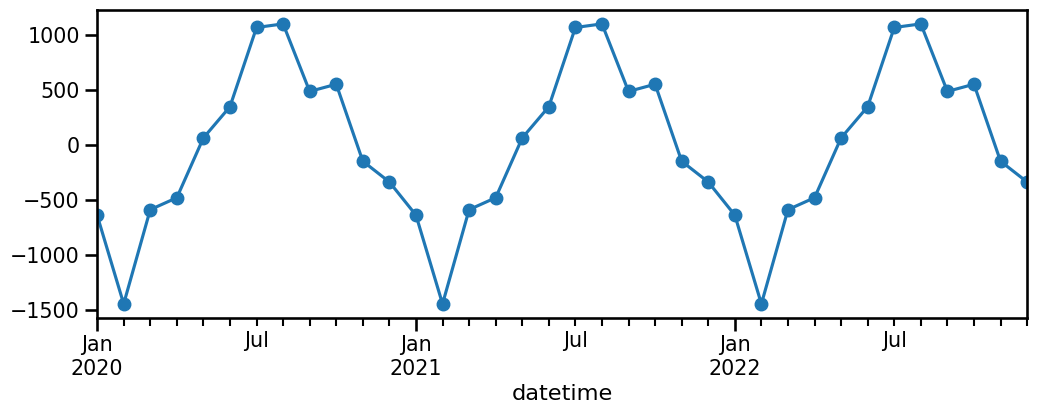

In [109]:
seasonal = decomp.seasonal
ax = seasonal.loc['2020': '2022'].plot(marker = 'o')

* M = 12

### Theft Model Preprocessing

In [110]:
d = ndiffs(ts)
print (f'd = {d}')

d = 1


In [111]:
D = nsdiffs(ts, m = 12)
print (f'D = {D}')

D = 0


In [112]:
ts_diff = ts.diff().dropna()

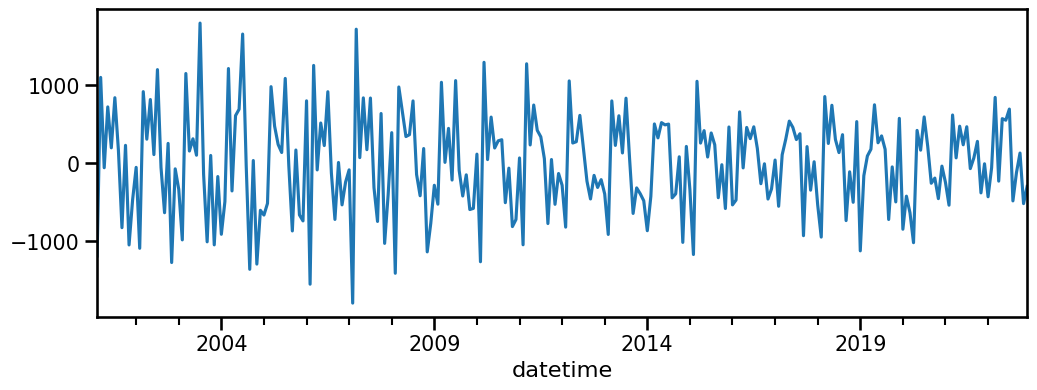

In [113]:
ts_diff.plot();

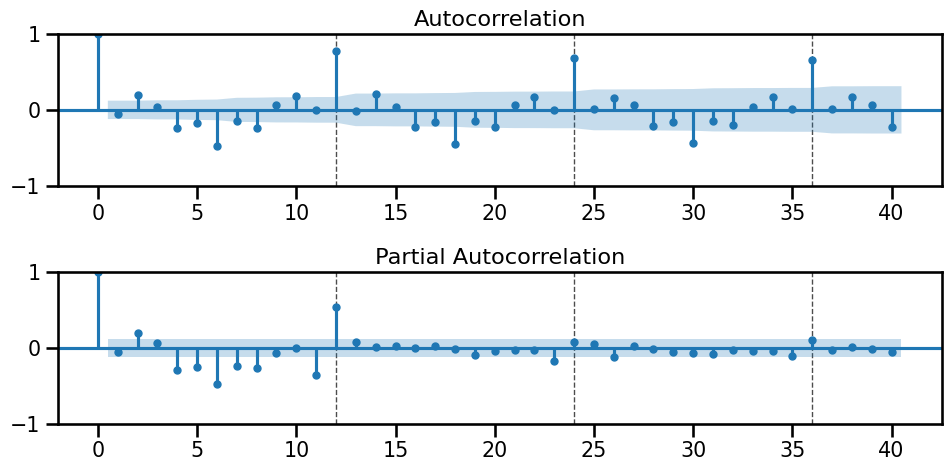

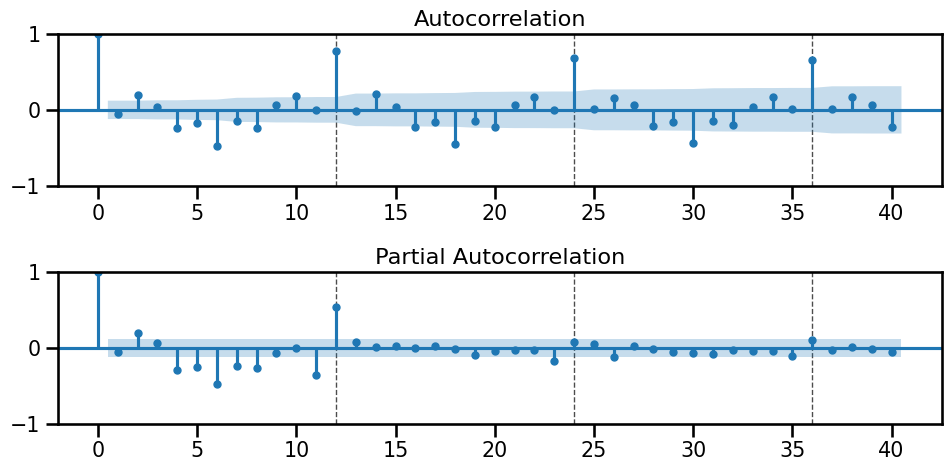

In [114]:
plot_acf_pacf(ts_diff, annotate_seas = True, m = 12)

In [115]:
nlag= 6

In [116]:
train, test = train_test_split(ts, test_size=nlag)

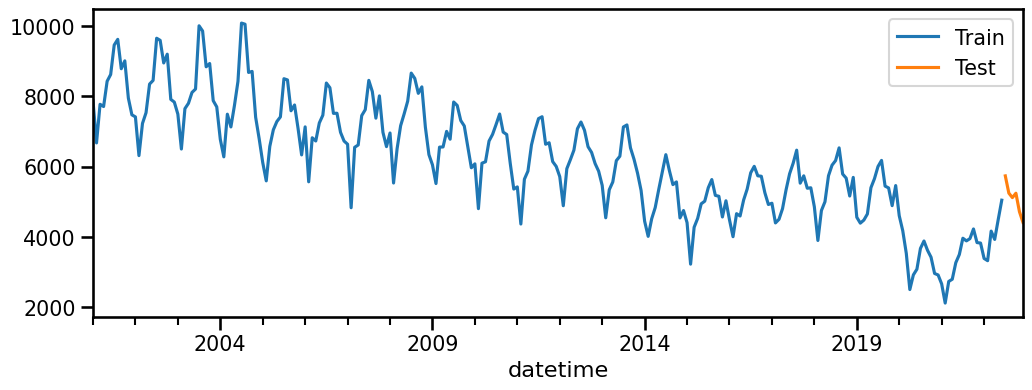

In [117]:
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [118]:
test.index

DatetimeIndex(['2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31'], dtype='datetime64[ns]', name='datetime', freq='M')

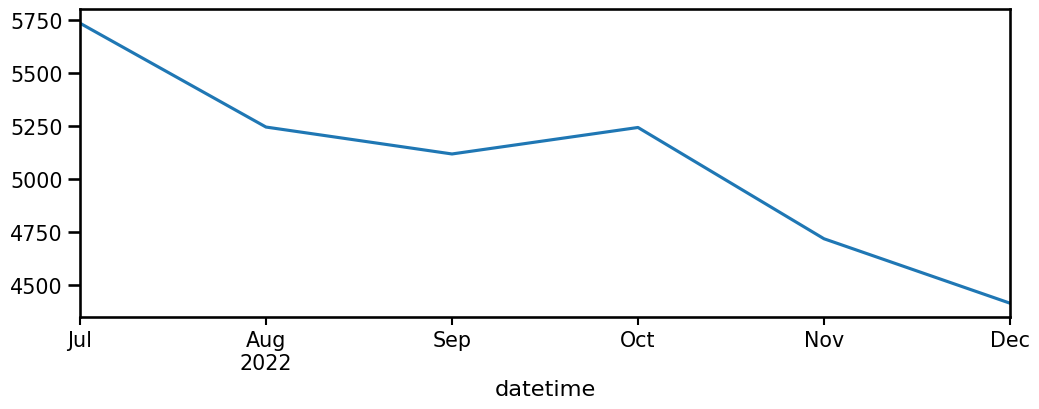

In [119]:
test.plot();

### Model 1

In [120]:
p = 0
d = 1
q = 1
P = 0
D = 0
Q = 1
m = 12

In [121]:
sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

In [122]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            THEFT   No. Observations:                  258
Model:             ARIMA(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -1953.364
Date:                          Thu, 12 Sep 2024   AIC                           3912.729
Time:                                  10:40:09   BIC                           3923.376
Sample:                              01-31-2001   HQIC                          3917.010
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1045      0.058     -1.803      0.071      -0.218       0.009
ma.S.L12       0.6288      0.053     11.915      0.000       0.525       0.732
sigma2      2.252e+05   2.26e+04      9.984      0.000    1.81e+05    2.69e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.42
Prob(Q):                              0.86   Prob(JB):                         0.30
Heteroskedasticity (H):               0.50   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

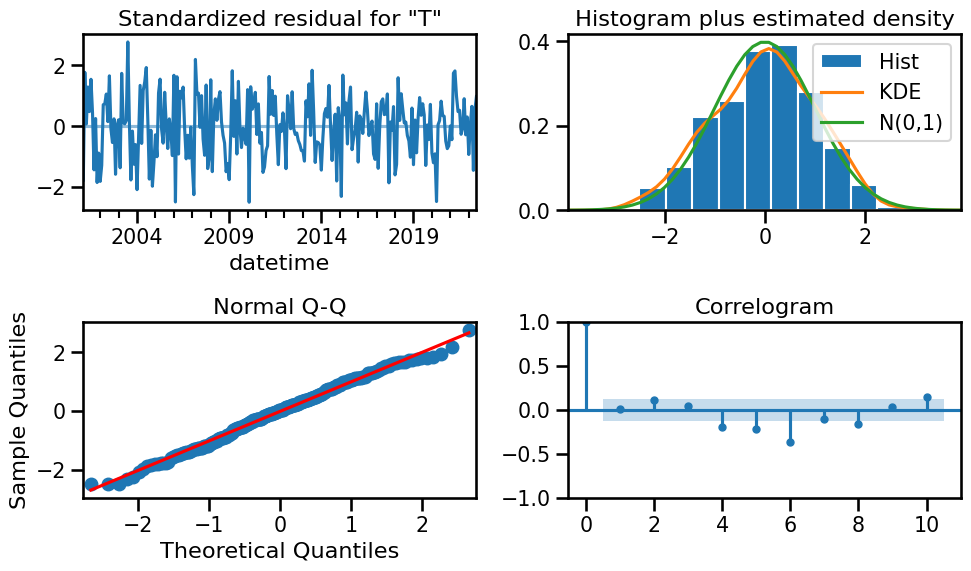

In [123]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [124]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()

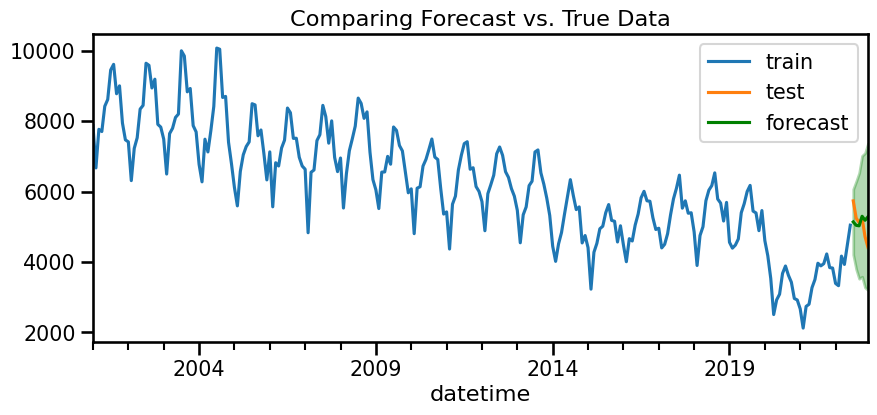

In [125]:
plot_forecast(train, test, forecast_df);

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


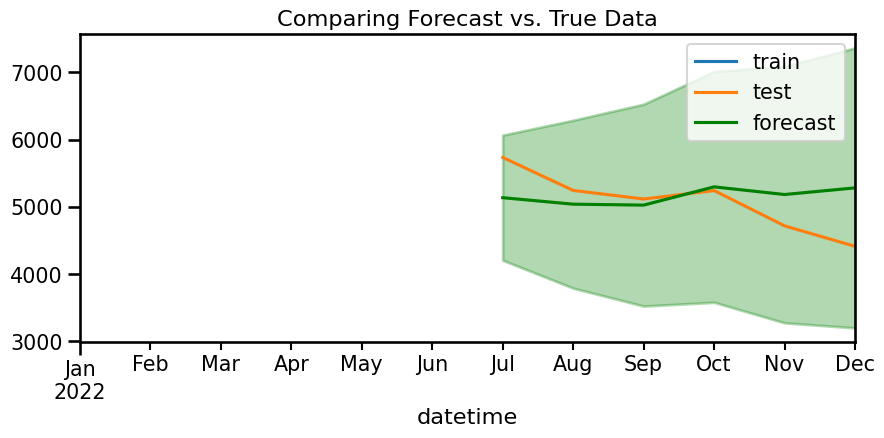

In [126]:
plot_forecast(train['01-2022'],test, forecast_df);

In [127]:
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 380.619
- MSE = 230,520.402
- RMSE = 480.125
- R^2 = -0.306
- MAPE = 7.79%


### Auto Arima (Model 2)

In [128]:
auto_model = pm.auto_arima(train,seasonal=True,m=12,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=19.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4050.524, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3791.710, Time=3.90 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3914.631, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4048.603, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4050.805, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3774.214, Time=3.75 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3743.853, Time=7.50 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3743.960, Time=2.12 sec


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,0)(2,0,2)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 703, in fit
    mlefit = super().fit(start_params, method=method,
  File "/usr/local/lib/python3.10/dist-packa

 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3742.900, Time=3.05 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3870.719, Time=1.23 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3913.736, Time=0.39 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3754.859, Time=2.46 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=3745.608, Time=7.32 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.78 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3742.926, Time=3.14 sec
 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=9.97 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=3741.268, Time=1.75 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=3868.767, Time=1.18 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=3742.307, Time=0.91 sec


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,0)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 703, in fit
    mlefit = super().fit(start_params, method=method,
  File "/usr/local/lib/python3.10/dist-packa

 ARIMA(1,1,0)(2,0,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=3911.819, Time=0.36 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=inf, Time=7.18 sec
 ARIMA(0,1,0)(1,0,2)[12]             : AIC=3753.387, Time=1.39 sec
 ARIMA(2,1,0)(1,0,2)[12]             : AIC=3743.206, Time=4.28 sec
 ARIMA(1,1,1)(1,0,2)[12]             : AIC=inf, Time=4.33 sec
 ARIMA(0,1,1)(1,0,2)[12]             : AIC=inf, Time=6.42 sec
 ARIMA(2,1,1)(1,0,2)[12]             : AIC=inf, Time=4.77 sec

Best model:  ARIMA(1,1,0)(1,0,2)[12]          
Total fit time: 108.046 seconds


In [129]:
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 0)
(1, 0, 2, 12)


In [130]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  258
Model:             SARIMAX(1, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -1865.634
Date:                                 Thu, 12 Sep 2024   AIC                           3741.268
Time:                                         10:42:02   BIC                           3759.013
Sample:                                     01-31-2001   HQIC                          3748.404
                                          - 06-30-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2251      0.046     -4.934      0.000      -0.315      -0.136
ar.S.L12       0.9778      0.008    120.049      0.000       0.962       0.994
ma.S.L12      -0.5771      0.059     -9.814      0.000      -0.692      -0.462
ma.S.L24      -0.1202      0.068     -1.758      0.079      -0.254       0.014
sigma2      1.038e+05   7353.367     14.120      0.000    8.94e+04    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                30.54
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.44
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

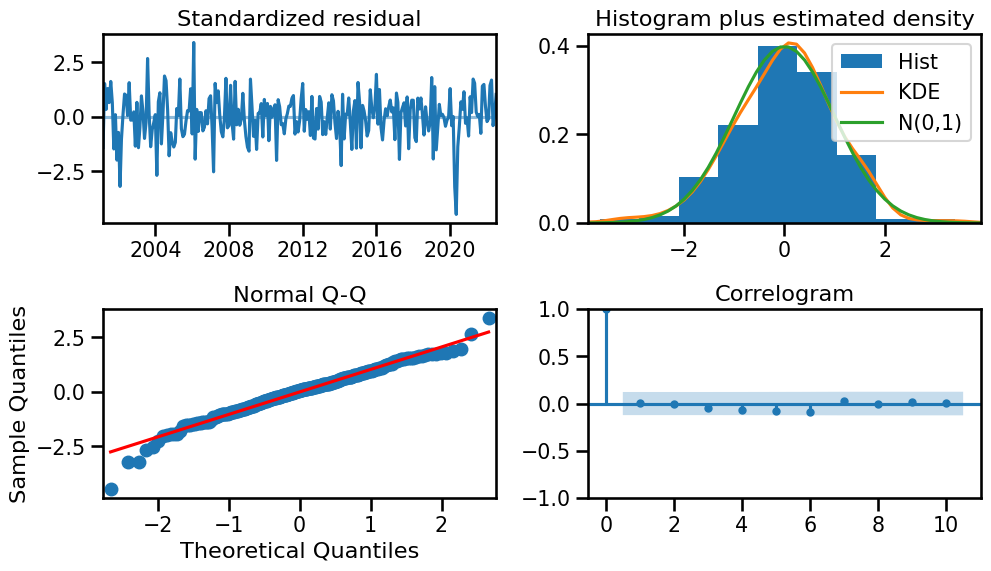

In [131]:
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [132]:
auto_model = tsa.ARIMA(train, order=auto_model.order, seasonal_order=auto_model.seasonal_order).fit()

In [133]:
forecast_df2 = auto_model.get_forecast(steps=len(test)).summary_frame()

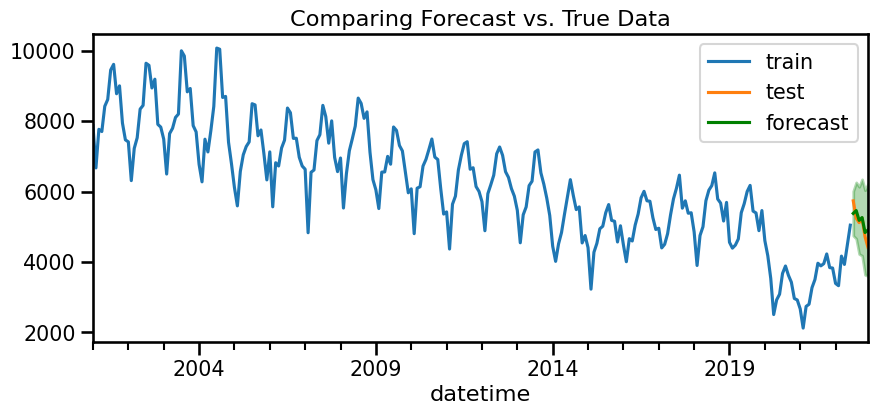

In [134]:
plot_forecast(train, test, forecast_df2);

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


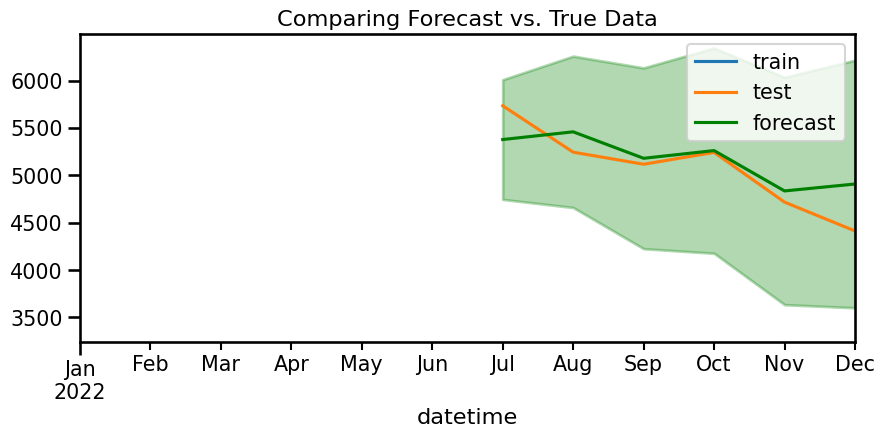

In [135]:
plot_forecast(train['01-2022'],test, forecast_df2);

In [136]:
regression_metrics_ts(test, forecast_df2['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.160
- MSE = 72,805.923
- RMSE = 269.826
- R^2 = 0.587
- MAPE = 4.27%


### Chosen Model

In [137]:
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 380.619
- MSE = 230,520.402
- RMSE = 480.125
- R^2 = -0.306
- MAPE = 7.79%


In [138]:
regression_metrics_ts(test, forecast_df2['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.160
- MSE = 72,805.923
- RMSE = 269.826
- R^2 = 0.587
- MAPE = 4.27%


* The chosen model is the auto arima (model #2) which had a better metric than the baseline model with 4.27% MAPE error rate, approximately half of what baseline model had achived in MAPE, and with 211 MAE for auto arima model which is 170 crime less in Mean Absolute Error than the baseline model.



###Final Model (6 Months Forecast)

In [139]:
p2 = 1
d2 = 1
q2 = 0
P2 = 1
D2 = 0
Q2 = 2
m = 12

In [140]:
final_model = tsa.ARIMA(ts, order = (p2,d2,q2), seasonal_order=(P2,D2,Q2,m)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [141]:
len(test)

6

In [142]:
final_forecast_df  = final_model.get_forecast(len(test)).summary_frame()

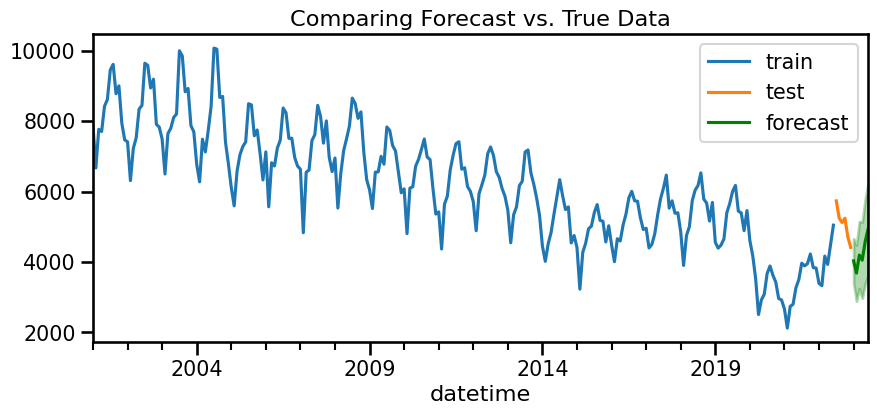

In [143]:
plot_forecast(train,test,final_forecast_df);

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


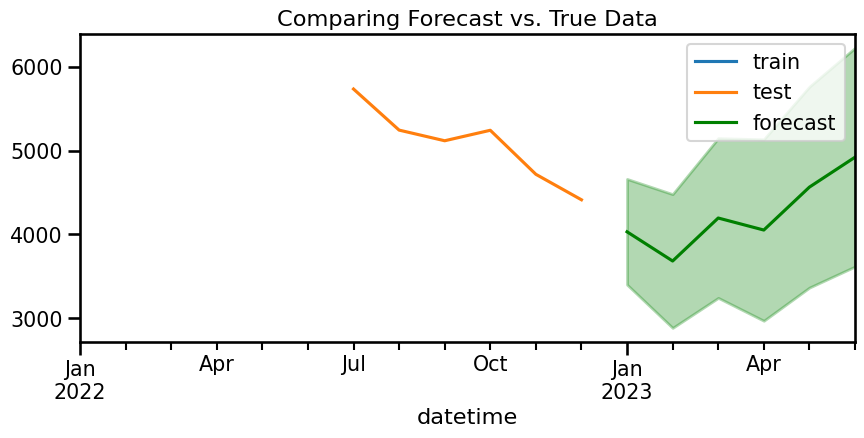

In [144]:
plot_forecast(train['01-2022'],test,final_forecast_df);

In [145]:
final_forecast_df.index[0],final_forecast_df.index[-1]

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [146]:
starting_value = final_forecast_df['mean'].iloc[0]
starting_value

4031.376577072557

In [147]:
final_value = final_forecast_df['mean'].iloc[-1]
final_value

4920.784934797009

In [148]:
change = final_value - starting_value
print(f'the predicted net change in raw counts of this type of crime (Theft) is {change:,.0f}')


the predicted net change in raw counts of this type of crime (Theft) is 889


In [149]:
perc_change = (change / starting_value) * 100
print(f'the predicted percent change in raw counts of this type of crime (Theft) is {perc_change:,.2f}%')

the predicted percent change in raw counts of this type of crime (Theft) is 22.06%


## Narcotics Modeling

### Data Inspection

In [150]:
crimes_ts_month.head()

Primary Type  ARSON  ASSAULT  BATTERY  BURGLARY  CONCEALED CARRY LICENSE VIOLATION  CRIMINAL DAMAGE  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  GAMBLING  HOMICIDE  HUMAN TRAFFICKING  INTERFERENCE WITH PUBLIC OFFICER  INTIMIDATION  KIDNAPPING  LIQUOR LAW VIOLATION  MOTOR VEHICLE THEFT  NARCOTICS  NON-CRIMINAL  OBSCENITY  OFFENSE INVOLVING CHILDREN  OTHER NARCOTIC VIOLATION  OTHER OFFENSE  PUBLIC INDECENCY  PUBLIC PEACE VIOLATION  RITUALISM  ROBBERY  STALKING  Sexual Crime  THEFT  WEAPONS VIOLATION
datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2001-01-31       67     2123     6527      1934                                  0             3966               1192                1398                  1        44        42                  0                                36            18          75                   101                 2097       4714             0          2                         246                         1           2800                 0                     161          2     1396        26           946   7867                337
2001-02-28       57     2029     6042      1666                                  0             3665               1063                1163                  0        37        27                  0                                27            24          57                   109                 1785       4369             0          1                         152                         0           2488                 1                     173          0     1159        13           710   6669                301
2001-03-31       93     2824     7662      1832                                  0             4617               1141                1313                  0        55        37                  0                                22            22          72                   147                 2151       4862             0          2                         195                         0           2836                 0                     267          2     1399        17           887   7766                345
2001-04-30       89     2746     8328      1932                                  0             4922               1133                1199                  0        79        59                  0                                34            21          49                   164                 2120       4044             0          2                         196                         0           2483                 1                     229          1     1341        29           867   7702                321
2001-05-31       94     2903     8887      1997                                  1             4757               1067                1261                  0        94        42                  0                                41            25          56                   194                 2197       4038             0          1                         213                         2           2528                 1                     239          1     1491        12           887   8420                390

In [151]:
crimes_ts_month['NARCOTICS'].head()

datetime
2001-01-31    4714
2001-02-28    4369
2001-03-31    4862
2001-04-30    4044
2001-05-31    4038
Freq: M, Name: NARCOTICS, dtype: int64

In [152]:
crimes_ts_month['NARCOTICS'].isna().sum()

0

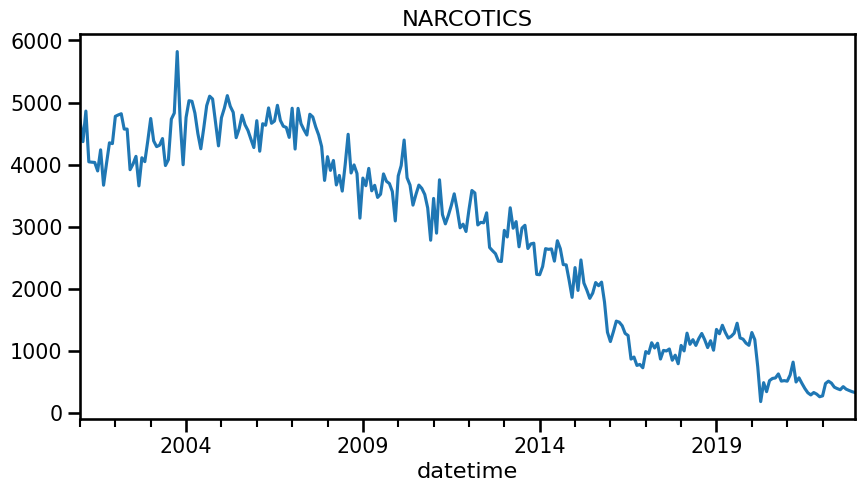

In [153]:
crimes_ts_month['NARCOTICS'].plot(kind='line',figsize=(10,5),title='NARCOTICS');

### Narcotics Seasonal Decompose

In [154]:
ts2 = crimes_ts_month['NARCOTICS']

In [155]:
decomp2 = tsa.seasonal_decompose(ts2)

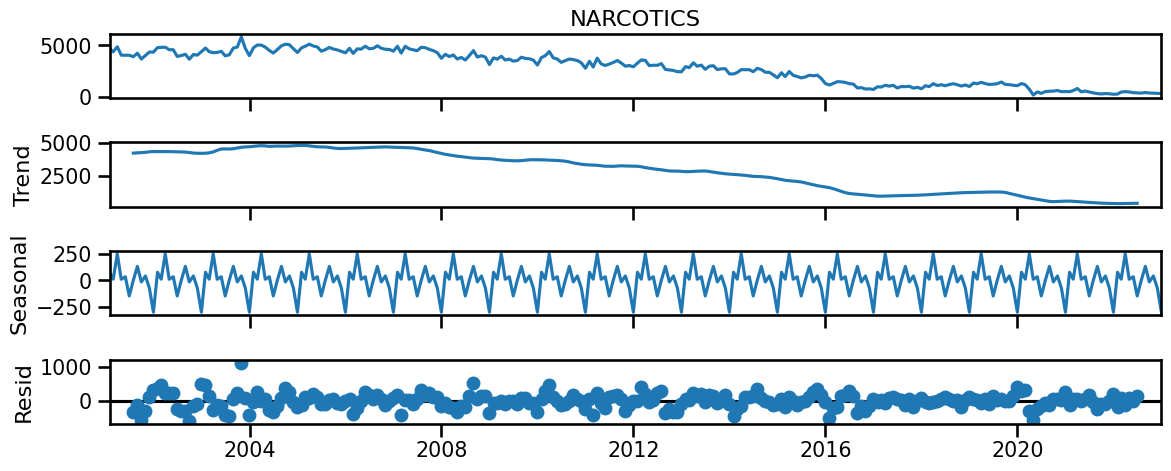

In [156]:
fig = decomp2.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [157]:
seasonal_delta2= decomp2.seasonal.max() - decomp2.seasonal.min()

In [158]:
print(f"The seasonal component is {seasonal_delta2: .2f} which is ~{seasonal_delta2/(ts2.max()-ts2.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is  550.66 which is ~9.76% of the variation in time series.


In [159]:
ts2.index.min()

Timestamp('2001-01-31 00:00:00')

In [160]:
ts2.index.max()

Timestamp('2022-12-31 00:00:00')

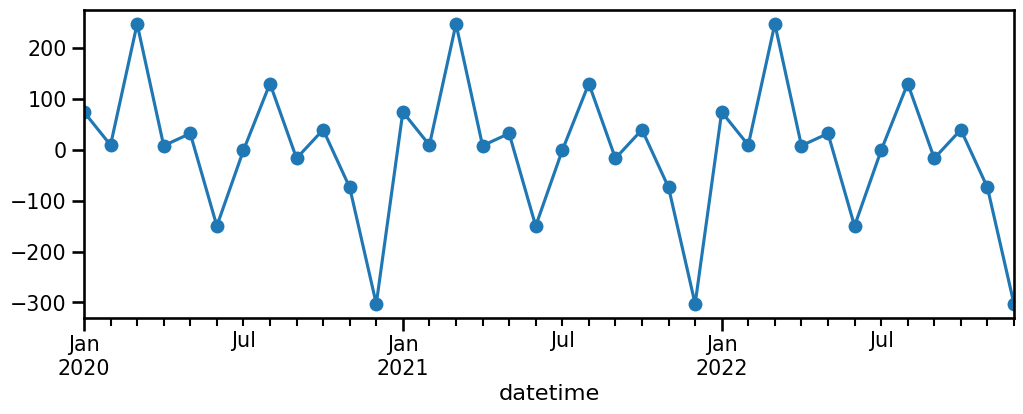

In [161]:
seasonal2 = decomp2.seasonal
ax2 = seasonal2.loc['2020': '2022'].plot(marker = 'o')

* M2 = 12

### Narcotics Model Preprocessing

In [163]:
d2 = ndiffs(ts2)
print (f'd2 = {d2}')

d2 = 1


In [165]:
D2 = nsdiffs(ts2, m= 12)
print (f'D2 = {D2}')

D2 = 0


In [166]:
ts_diff2 = ts2.diff().dropna()

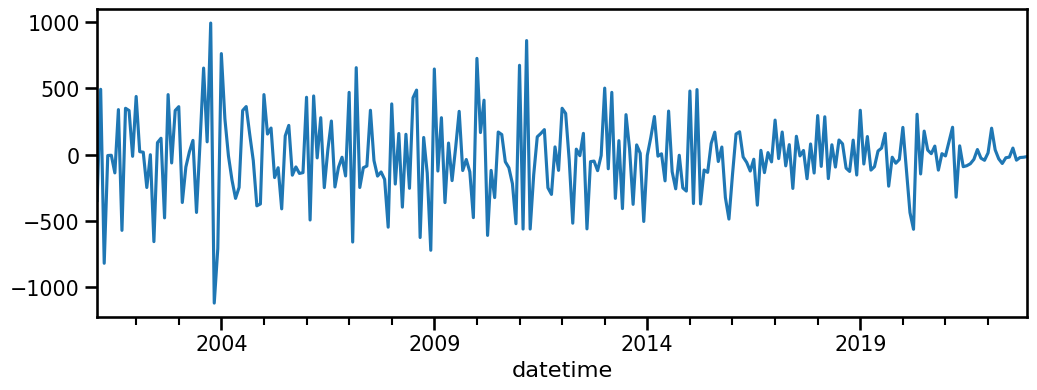

In [167]:
ts_diff2.plot();

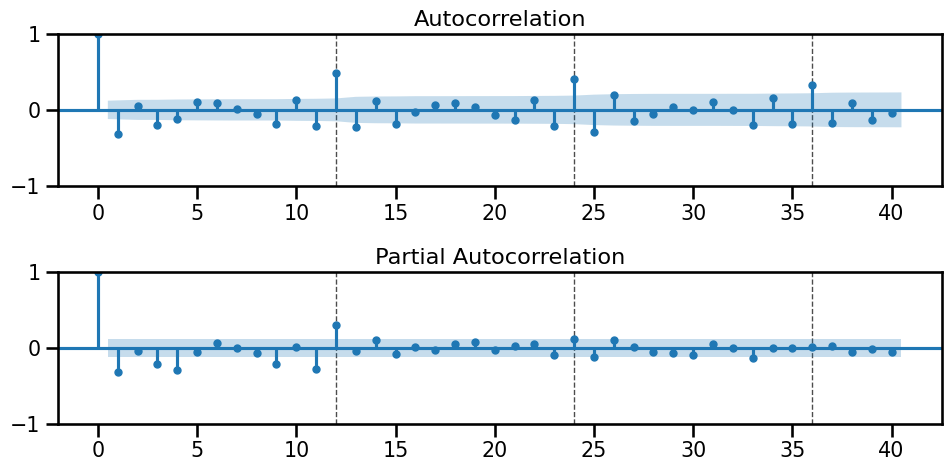

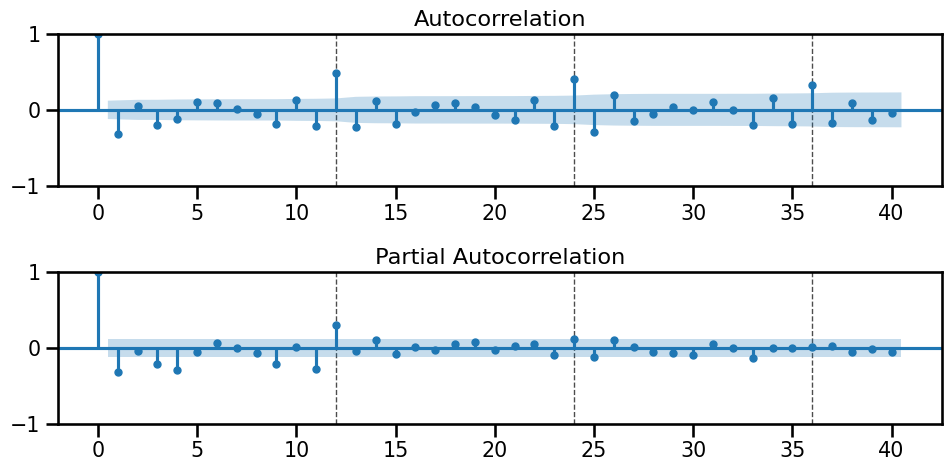

In [168]:
plot_acf_pacf(ts_diff2, annotate_seas = True, m = 12)

In [170]:
nlag2= 6

In [171]:
train2, test2 = train_test_split(ts2, test_size=nlag2)

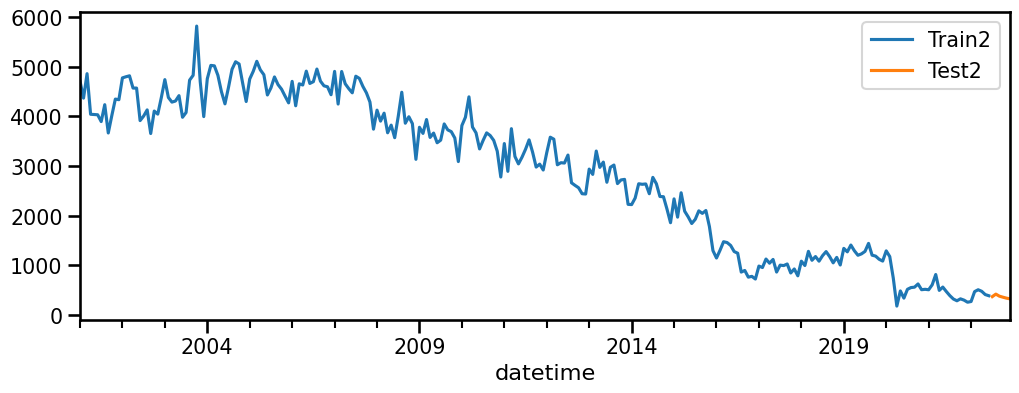

In [173]:
ax3 = train2.plot(label='Train2')
test2.plot(ax=ax3, label='Test2')
ax3.legend();

In [174]:
test2.index

DatetimeIndex(['2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31'], dtype='datetime64[ns]', name='datetime', freq='M')

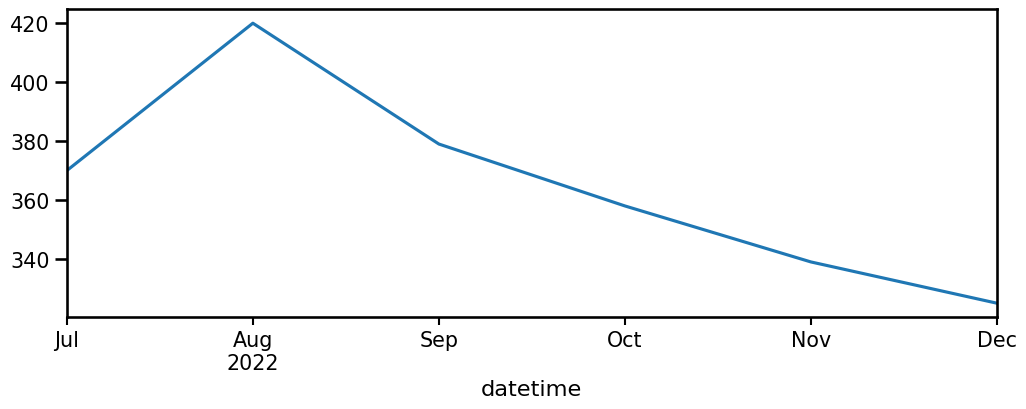

In [175]:
test2.plot();

### Model 1

In [176]:
p4 = 0
d4 = 1
q4 = 1
P4 = 0
D4 = 0
Q4 = 1
m2 = 12

In [177]:
sarima2 = tsa.ARIMA(train2, order = (p4,d4,q4), seasonal_order=(P4,D4,Q4,m2)).fit()

In [178]:
sarima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        NARCOTICS   No. Observations:                  258
Model:             ARIMA(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -1794.734
Date:                          Thu, 12 Sep 2024   AIC                           3595.469
Time:                                  11:04:12   BIC                           3606.116
Sample:                              01-31-2001   HQIC                          3599.751
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4123      0.044     -9.303      0.000      -0.499      -0.325
ma.S.L12       0.3574      0.058      6.156      0.000       0.244       0.471
sigma2      6.802e+04   4467.872     15.224      0.000    5.93e+04    7.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                38.29
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

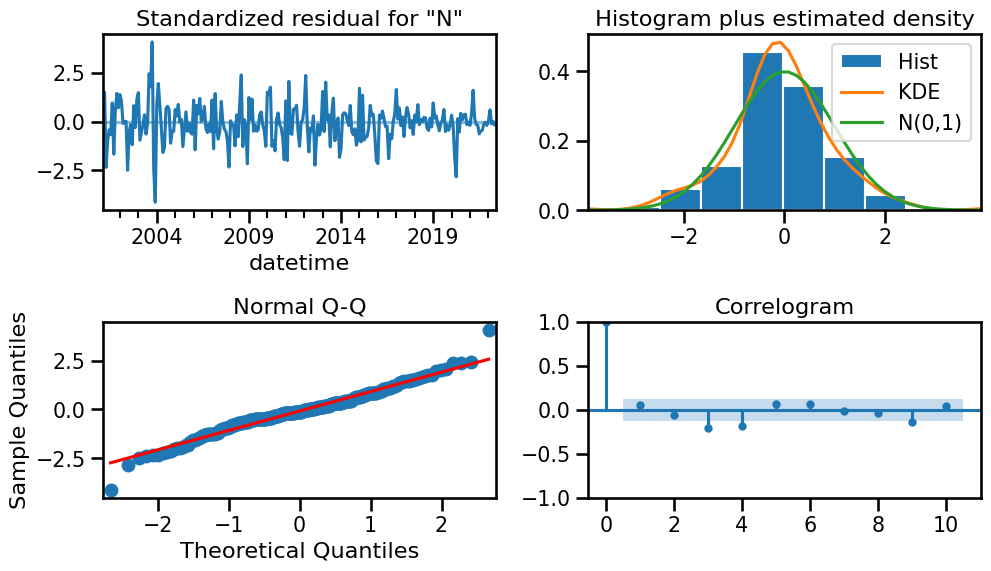

In [179]:
fig = sarima2.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [180]:
forecast_df4 = sarima2.get_forecast(steps=len(test2)).summary_frame()

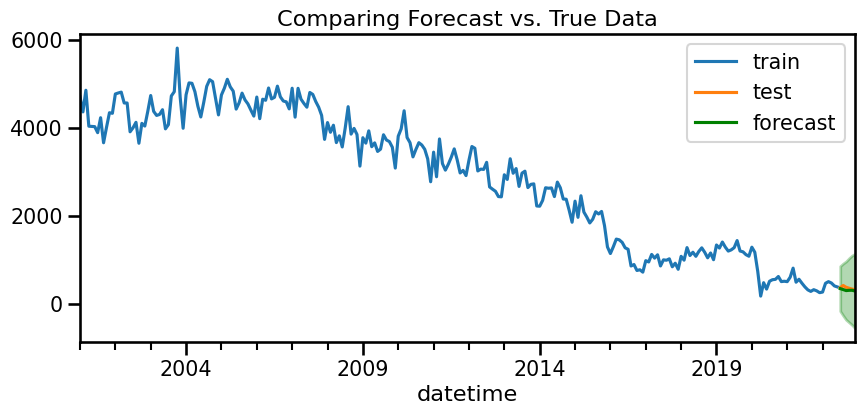

In [181]:
plot_forecast(train2, test2, forecast_df4);

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


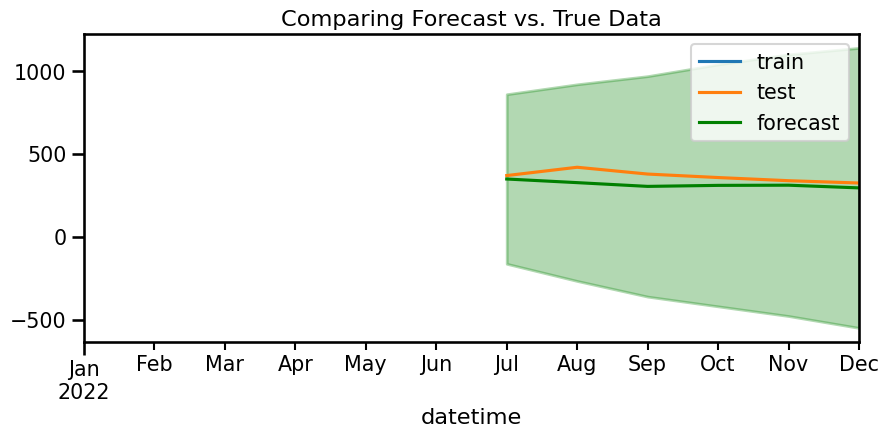

In [182]:
plot_forecast(train2['01-2022'],test2, forecast_df4);

In [183]:
regression_metrics_ts(test2, forecast_df4['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 48.602
- MSE = 3,063.779
- RMSE = 55.351
- R^2 = -2.300
- MAPE = 12.93%


### Auto Arima (Model 2)

In [184]:
auto_model2 = pm.auto_arima(train2,seasonal=True,m=12,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=7.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3669.016, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3583.957, Time=0.63 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3595.909, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3667.813, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3643.189, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3577.354, Time=1.79 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3559.635, Time=3.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3559.679, Time=4.78 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.79 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3559.353, Time=4.03 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3589.825, Time=1.14 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3602.922, Time=0.38 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3566.666, Time=6.54 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [186]:
print(auto_model2.order)
print(auto_model2.seasonal_order)

(4, 1, 0)
(1, 0, 1, 12)


In [187]:
auto_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  258
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1764.670
Date:                              Thu, 12 Sep 2024   AIC                           3543.341
Time:                                      11:10:08   BIC                           3568.184
Sample:                                  01-31-2001   HQIC                          3553.332
                                       - 06-30-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2524      0.042     -5.976      0.000      -0.335      -0.170
ar.L2         -0.1862      0.053     -3.528      0.000      -0.290      -0.083
ar.L3         -0.2032      0.058     -3.488      0.000      -0.317      -0.089
ar.L4         -0.1967      0.061     -3.247      0.001      -0.315      -0.078
ar.S.L12       0.9384      0.032     29.749      0.000       0.877       1.000
ma.S.L12      -0.7208      0.081     -8.953      0.000      -0.879      -0.563
sigma2      5.296e+04   3683.362     14.379      0.000    4.57e+04    6.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                38.52
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

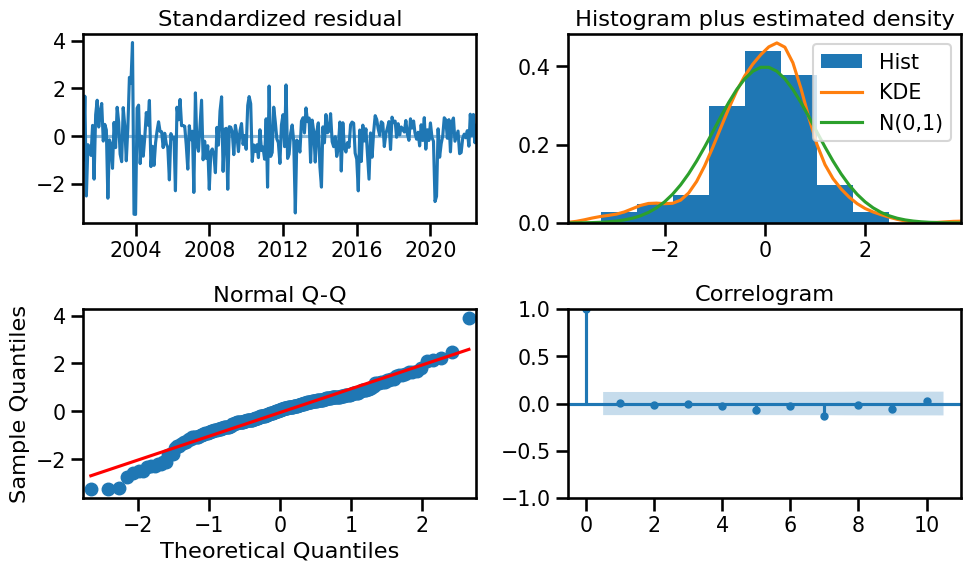

In [188]:
fig = auto_model2.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [189]:
auto_model2 = tsa.ARIMA(train2, order=auto_model2.order, seasonal_order=auto_model2.seasonal_order).fit()

In [190]:
forecast_df5 = auto_model2.get_forecast(steps=len(test2)).summary_frame()

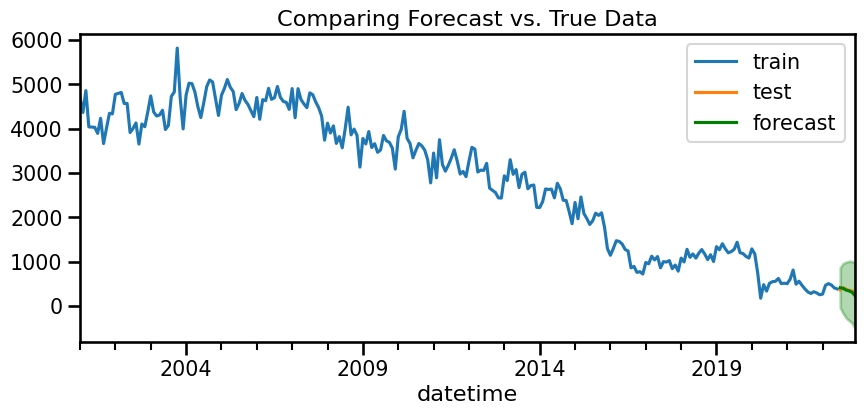

In [191]:
plot_forecast(train2, test2, forecast_df5);

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


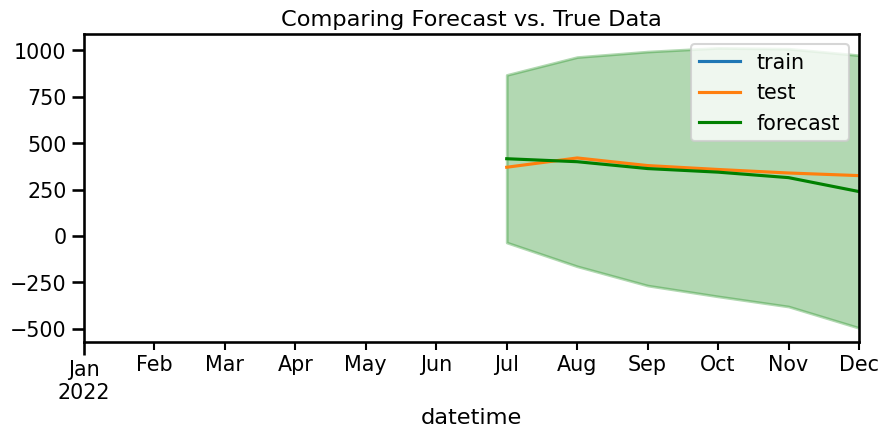

In [192]:
plot_forecast(train2['01-2022'],test2, forecast_df5);

In [193]:
regression_metrics_ts(test2, forecast_df5['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 34.565
- MSE = 1,829.463
- RMSE = 42.772
- R^2 = -0.970
- MAPE = 9.88%


### Chosen Model

In [194]:
regression_metrics_ts(test2, forecast_df4['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 48.602
- MSE = 3,063.779
- RMSE = 55.351
- R^2 = -2.300
- MAPE = 12.93%


In [195]:
regression_metrics_ts(test2, forecast_df5['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 34.565
- MSE = 1,829.463
- RMSE = 42.772
- R^2 = -0.970
- MAPE = 9.88%


* The chosen model is the auto arima (model #2) which had a better metric than the baseline model with 9.88% MAPE error rate, which is around 3% less of what baseline model had achived in MAPE, and with 34.5 MAE for auto arima model which is 14 crime less in Mean Absolute Error than the baseline model.



###Final Model (6 Months Forecast)

In [196]:
pf = 4
df = 1
qf = 0
Pf = 1
Df = 0
Qf = 2
m = 12

In [197]:
final_model2 = tsa.ARIMA(ts2, order = (pf,df,qf), seasonal_order=(Pf,Df,Qf,m)).fit()

In [198]:
len(test2)

6

In [199]:
final_forecast_df2  = final_model2.get_forecast(len(test2)).summary_frame()

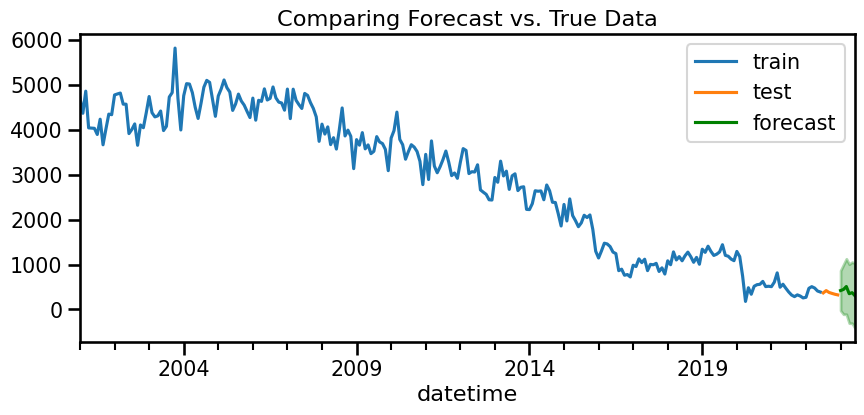

In [200]:
plot_forecast(train2,test2,final_forecast_df2);

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


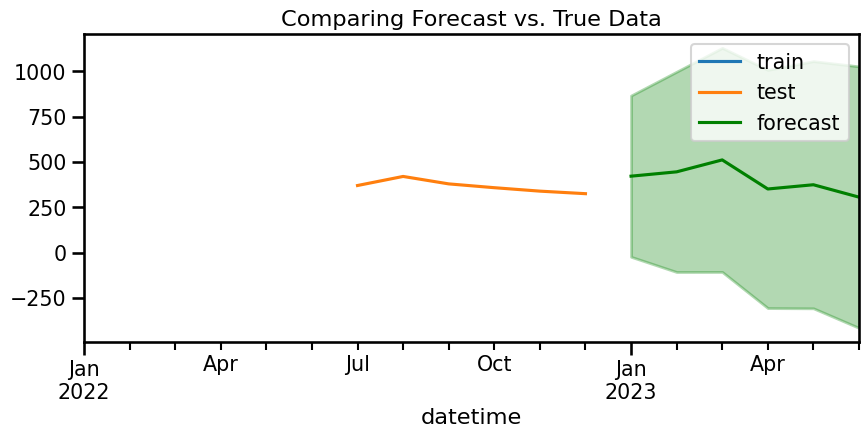

In [201]:
plot_forecast(train2['01-2022'],test2,final_forecast_df2);

In [202]:
final_forecast_df2.index[0],final_forecast_df2.index[-1]

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [203]:
starting_value2 = final_forecast_df2['mean'].iloc[0]
starting_value2

421.5179926539625

In [204]:
final_value2 = final_forecast_df2['mean'].iloc[-1]
final_value2

305.95961374968005

In [205]:
change2 = final_value2 - starting_value2
print(f'the predicted net change in raw counts of this type of crime (Narcotics) is {change2:,.0f}')


the predicted net change in raw counts of this type of crime (Narcotics) is -116


In [206]:
perc_change2 = (change2 / starting_value2) * 100
print(f'the predicted percent change in raw counts of this type of crime (Narcotics) is {perc_change2:,.2f}%')

the predicted percent change in raw counts of this type of crime (Narcotics) is -27.41%


## Final Evaluation

In [211]:
print(f'the predicted raw counts of Theft cirmes ({round(final_value)}) is higher than the predicted raw counts of Narcotics crimes ({round(final_value2)})')

the predicted raw counts of Theft cirmes (4921) is higher than the predicted raw counts of Narcotics crimes (306)


In [214]:
print(f'the predicted net change of Theft ({round(change)}) is higher than the predicted net change of Narcotics ({round(change2)})')

the predicted net change of Theft (889) is higher than the predicted net change of Narcotics (-116)


In [217]:
print(f'the predicted percent change of Theft ({round(perc_change)}%) is higher than the predicted percent change of Narcotics ({round(perc_change2)}%)')

the predicted percent change of Theft (22%) is higher than the predicted percent change of Narcotics (-27%)


# Final Recommendations

In [234]:
print('I would Recommend using Theft Model for theft cirmes forecasting into the future since it has about 96% rate of prediction success as shown below with the metrics \n'),regression_metrics_ts(test, forecast_df2['mean'])

I would Recommend using Theft Model for theft cirmes forecasting into the future since it has about 96% rate of prediction success as shown below with the metrics 

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.160
- MSE = 72,805.923
- RMSE = 269.826
- R^2 = 0.587
- MAPE = 4.27%


(None, None)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


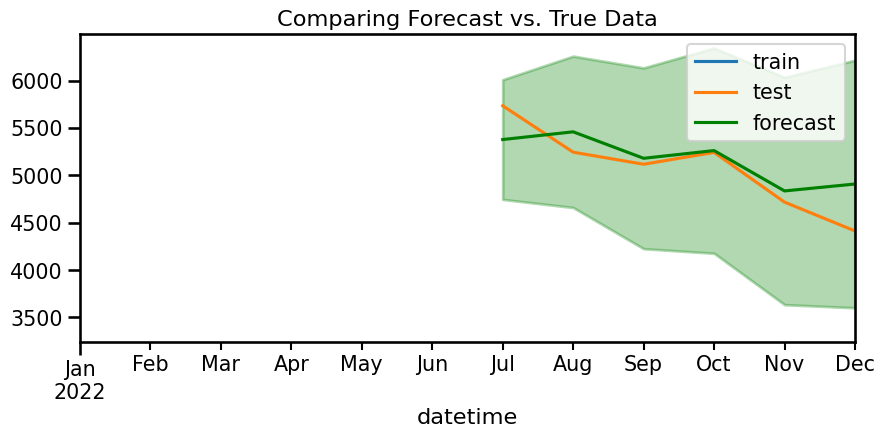

In [236]:
plot_forecast(train['01-2022'],test, forecast_df2);

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


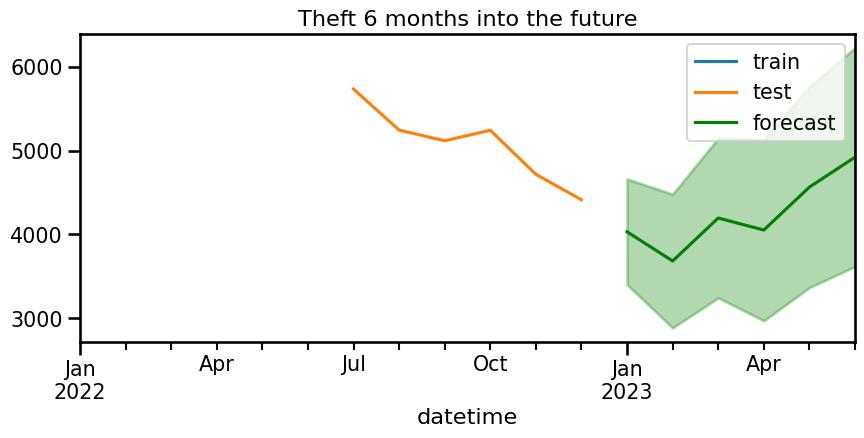

In [237]:
plot_forecast(train['01-2022'],test,final_forecast_df,title='Theft 6 months into the future');